In [1]:
%load_ext autoreload
%autoreload 2

import glob
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from pathlib import Path


import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn

from torchvision.utils import make_grid
from torchvision.models  import resnet101, ResNet101_Weights
from torchvision import models
from torchvision.io import read_image
from torchvision.transforms import Resize


import time
import copy
from tqdm import tqdm


# from torchsummary import summary
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
 

import matplotlib.patches as patches
import ast  # For literal_eval to convert string to dictionary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)


PyTorch Version:  2.0.0
Torchvision Version:  0.15.0


In [2]:
np.random.seed(31101995)
torch.manual_seed(31101995)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
# Set seed
seed_everything(31101995)

# DATASET:

> 1. Link: https://www.kaggle.com/datasets/hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection/data
> 2. VehiDE Dataset: Automatic vehicle damage detection

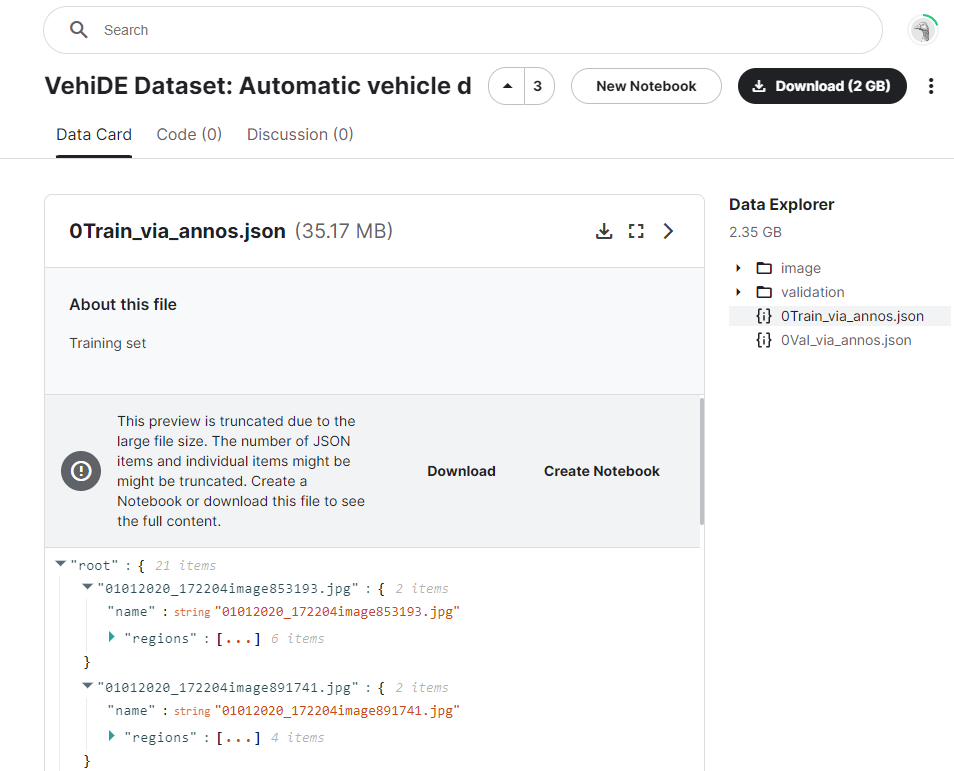

**About Dataset**


In the world of auto insurance, automatic car damage identification has garnered a lot of interest. However,
it is difficult for us to develop a workable model for car damage identification due to the absence of high-quality datasets that are accessible to the general public. In order to achieve this, the Vehicle Damage Detection (VehiDE) dataset, the large-scale dataset made available to the public for the purpose of segmenting and detecting visual automotive damage. This dataset comprises 13,945 high-resolution photos of damaged cars together with more than 32,000 occurrences of each damage category with detailed annotations. Statistical dataset analysis is provided together with a description of the image collecting, selection, and annotation procedures. In order to emphasize
the expertise of automotive damage identification, extensive experiments on the VehiDE dataset are conducted using cutting-edge deep approaches for a variety of jobs and provide thorough analysis.

# 1. Read data using json

In [3]:
# Assuming your JSON file is named 'your_file.json'
json_file_path = '/home/shsingh/knowledge_distillation/Car_damage_detection/0Train_via_annos.json'

def get_image_path(x):
    image_root_path = '/home/shsingh/knowledge_distillation/Car_damage_detection/image/image'
    return f'{image_root_path}/{x}'


# Load JSON file into a DataFrame
df = pd.read_json(json_file_path)
df = df.T.reset_index(drop=True)
df['image_path'] = df['name'].apply(lambda x: get_image_path(x))
df

name  \
0                         01012020_172204image853193.jpg   
1                         01012020_172204image891741.jpg   
2                          01012020_172251image12370.jpg   
3                         01022020_083952image768902.jpg   
4                         01022020_102246image365727.jpg   
...                                                  ...   
11616  z2243796268779_2cadfc39a0bc5c92fa2b6d6560699ae...   
11617  z2246123119712_3cb5dbd5a8628e87dabe68e7f25c754...   
11618  z2247452590065_f564385937849ea15551c31edd6a841...   
11619  z2613326143146_1a2ac98d506eab5651d5a79a70cbd91...   
11620  z2669260231605_44c66996f57e4127d3b692ed7cf8c2d...   

                                                 regions  \
0      [{'all_x': [1, 30, 81, 79, 74, 65, 63, 65, 83,...   
1      [{'all_x': [-1, 2, 41, 107, 127, 179, 200, 233...   
2      [{'all_x': [220, 212, 213, 224, 241, 253, 262,...   
3      [{'all_x': [228, 224, 229, 237, 231], 'all_y':...   
4      [{'all_x': [897, 866, 853, 873, 927, 945, 958,...   
...                                                  ...   
11616  [{'all_x': [618, 686, 847, 858, 816, 717, 572,...   
11617  [{'all_x': [420, 431, 440, 448, 440, 426, 420,...   
11618  [{'all_x': [-2, 130, 320, 426, 501, 525, 541, ...   
11619  [{'all_x': [469, 533, 780, 883, 906, 975, 1023...   
11620  [{'all_x': [92, 2, 0, 51, 128, 183, 263, 378, ...   

                                              image_path  
0      /home/shsingh/knowledge_distillation/Car_damag...  
1      /home/shsingh/knowledge_distillation/Car_damag...  
2      /home/shsingh/knowledge_distillation/Car_damag...  
3      /home/shsingh/knowledge_distillation/Car_damag...  
4      /home/shsingh/knowledge_distillation/Car_damag...  
...                                                  ...  
11616  /home/shsingh/knowledge_distillation/Car_damag...  
11617  /home/shsingh/knowledge_distillation/Car_damag...  
11618  /home/shsingh/knowledge_distillation/Car_damag...  
11619  /home/shsingh/knowledge_distillation/Car_damag...  
11620  /home/shsingh/knowledge_distillation/Car_damag...  

[11621 rows x 3 columns]

# 2. Prepare data

In [4]:
import cv2
import numpy as np
import pandas as pd

# Function to calculate area from polygon coordinates
def calculate_polygon_area(all_x, all_y):
    points = np.array(list(zip(all_x, all_y)), dtype=np.int32)
    points = points.reshape((-1, 1, 2))
    area = cv2.contourArea(points)
    return area

# Create a new column for total damaged area
df['total_damage_area_cv2'] = df['regions'].apply(lambda x: sum(calculate_polygon_area(entry['all_x'], entry['all_y']) for entry in x))
df

name  \
0                         01012020_172204image853193.jpg   
1                         01012020_172204image891741.jpg   
2                          01012020_172251image12370.jpg   
3                         01022020_083952image768902.jpg   
4                         01022020_102246image365727.jpg   
...                                                  ...   
11616  z2243796268779_2cadfc39a0bc5c92fa2b6d6560699ae...   
11617  z2246123119712_3cb5dbd5a8628e87dabe68e7f25c754...   
11618  z2247452590065_f564385937849ea15551c31edd6a841...   
11619  z2613326143146_1a2ac98d506eab5651d5a79a70cbd91...   
11620  z2669260231605_44c66996f57e4127d3b692ed7cf8c2d...   

                                                 regions  \
0      [{'all_x': [1, 30, 81, 79, 74, 65, 63, 65, 83,...   
1      [{'all_x': [-1, 2, 41, 107, 127, 179, 200, 233...   
2      [{'all_x': [220, 212, 213, 224, 241, 253, 262,...   
3      [{'all_x': [228, 224, 229, 237, 231], 'all_y':...   
4      [{'all_x': [897, 866, 853, 873, 927, 945, 958,...   
...                                                  ...   
11616  [{'all_x': [618, 686, 847, 858, 816, 717, 572,...   
11617  [{'all_x': [420, 431, 440, 448, 440, 426, 420,...   
11618  [{'all_x': [-2, 130, 320, 426, 501, 525, 541, ...   
11619  [{'all_x': [469, 533, 780, 883, 906, 975, 1023...   
11620  [{'all_x': [92, 2, 0, 51, 128, 183, 263, 378, ...   

                                              image_path  \
0      /home/shsingh/knowledge_distillation/Car_damag...   
1      /home/shsingh/knowledge_distillation/Car_damag...   
2      /home/shsingh/knowledge_distillation/Car_damag...   
3      /home/shsingh/knowledge_distillation/Car_damag...   
4      /home/shsingh/knowledge_distillation/Car_damag...   
...                                                  ...   
11616  /home/shsingh/knowledge_distillation/Car_damag...   
11617  /home/shsingh/knowledge_distillation/Car_damag...   
11618  /home/shsingh/knowledge_distillation/Car_damag...   
11619  /home/shsingh/knowledge_distillation/Car_damag...   
11620  /home/shsingh/knowledge_distillation/Car_damag...   

       total_damage_area_cv2  
0                   156392.0  
1                   237672.5  
2                   224911.0  
3                   676724.0  
4                   662169.5  
...                      ...  
11616                70403.0  
11617              1201401.0  
11618                19887.5  
11619               223878.5  
11620               395520.0  

[11621 rows x 4 columns]

In [12]:
def get_region_class(x):
    return [region['class'] for region in x]
    
    
df['regions_label'] =df['regions'].apply(get_region_class)
df

name  \
0                         01012020_172204image853193.jpg   
1                         01012020_172204image891741.jpg   
2                          01012020_172251image12370.jpg   
3                         01022020_083952image768902.jpg   
4                         01022020_102246image365727.jpg   
...                                                  ...   
11616  z2243796268779_2cadfc39a0bc5c92fa2b6d6560699ae...   
11617  z2246123119712_3cb5dbd5a8628e87dabe68e7f25c754...   
11618  z2247452590065_f564385937849ea15551c31edd6a841...   
11619  z2613326143146_1a2ac98d506eab5651d5a79a70cbd91...   
11620  z2669260231605_44c66996f57e4127d3b692ed7cf8c2d...   

                                                 regions  \
0      [{'all_x': [1, 30, 81, 79, 74, 65, 63, 65, 83,...   
1      [{'all_x': [-1, 2, 41, 107, 127, 179, 200, 233...   
2      [{'all_x': [220, 212, 213, 224, 241, 253, 262,...   
3      [{'all_x': [228, 224, 229, 237, 231], 'all_y':...   
4      [{'all_x': [897, 866, 853, 873, 927, 945, 958,...   
...                                                  ...   
11616  [{'all_x': [618, 686, 847, 858, 816, 717, 572,...   
11617  [{'all_x': [420, 431, 440, 448, 440, 426, 420,...   
11618  [{'all_x': [-2, 130, 320, 426, 501, 525, 541, ...   
11619  [{'all_x': [469, 533, 780, 883, 906, 975, 1023...   
11620  [{'all_x': [92, 2, 0, 51, 128, 183, 263, 378, ...   

                                              image_path  \
0      /home/shsingh/knowledge_distillation/Car_damag...   
1      /home/shsingh/knowledge_distillation/Car_damag...   
2      /home/shsingh/knowledge_distillation/Car_damag...   
3      /home/shsingh/knowledge_distillation/Car_damag...   
4      /home/shsingh/knowledge_distillation/Car_damag...   
...                                                  ...   
11616  /home/shsingh/knowledge_distillation/Car_damag...   
11617  /home/shsingh/knowledge_distillation/Car_damag...   
11618  /home/shsingh/knowledge_distillation/Car_damag...   
11619  /home/shsingh/knowledge_distillation/Car_damag...   
11620  /home/shsingh/knowledge_distillation/Car_damag...   

       total_damage_area_cv2  \
0                   156392.0   
1                   237672.5   
2                   224911.0   
3                   676724.0   
4                   662169.5   
...                      ...   
11616                70403.0   
11617              1201401.0   
11618                19887.5   
11619               223878.5   
11620               395520.0   

                                           regions_label  
0      [mat_bo_phan, rach, rach, mop_lom, tray_son, t...  
1                [mat_bo_phan, rach, tray_son, tray_son]  
2      [rach, mop_lom, tray_son, rach, rach, mat_bo_p...  
3                                    [rach, mat_bo_phan]  
4      [rach, tray_son, tray_son, tray_son, tray_son,...  
...                                                  ...  
11616                                     [thung, thung]  
11617                     [thung, thung, rach, tray_son]  
11618                                          [vo_kinh]  
11619                         [mat_bo_phan, mat_bo_phan]  
11620                                      [mat_bo_phan]  

[11621 rows x 5 columns]

In [19]:
all_reg = []
for region_label in df['regions_label'].values:
    all_reg.extend(region_label)
    
    
print(np.unique(all_reg))
print(set(all_reg))
len(np.unique(all_reg))

['be_den' 'mat_bo_phan' 'mop_lom' 'rach' 'thung' 'tray_son' 'vo_kinh']
{'rach', 'vo_kinh', 'be_den', 'mat_bo_phan', 'tray_son', 'mop_lom', 'thung'}


7

In [26]:
df['regions'][0]

[{'all_x': [1,
   30,
   81,
   79,
   74,
   65,
   63,
   65,
   83,
   100,
   126,
   187,
   208,
   228,
   300,
   351,
   394,
   447,
   438,
   425,
   408,
   389,
   373,
   301,
   258,
   211,
   189,
   189,
   2],
  'all_y': [107,
   118,
   184,
   157,
   131,
   98,
   86,
   83,
   110,
   165,
   245,
   417,
   464,
   481,
   535,
   554,
   568,
   578,
   444,
   392,
   336,
   256,
   191,
   171,
   135,
   69,
   22,
   1,
   1],
  'class': 'mat_bo_phan'},
 {'all_x': [395,
   457,
   528,
   621,
   667,
   705,
   752,
   772,
   792,
   798,
   799,
   775,
   754,
   728,
   710,
   659,
   579,
   506,
   485,
   479,
   389],
  'all_y': [256,
   264,
   267,
   267,
   268,
   277,
   294,
   301,
   300,
   296,
   247,
   264,
   272,
   276,
   270,
   243,
   251,
   255,
   250,
   245,
   231],
  'class': 'rach'},
 {'all_x': [440,
   461,
   485,
   509,
   548,
   620,
   695,
   737,
   738,
   727,
   673,
   625,
   596,
   555,
   449],
  'a

# 3. Create mask using classes

In [24]:
seg_labels = ['rach', 'vo_kinh', 'be_den', 'mat_bo_phan', 'tray_son', 'mop_lom', 'thung']
seg_labels_dict={}
for i in range(0,len(seg_labels)):
    print(i, seg_labels[i])
    seg_labels_dict[seg_labels[i]] = i
    
seg_labels_dict

0 rach
1 vo_kinh
2 be_den
3 mat_bo_phan
4 tray_son
5 mop_lom
6 thung


{'rach': 0,
 'vo_kinh': 1,
 'be_den': 2,
 'mat_bo_phan': 3,
 'tray_son': 4,
 'mop_lom': 5,
 'thung': 6}

### 3.1. Clean the data as some images are corrupt and fails to load

In [42]:
def find_corrupt_images(image_paths_column):
    corrupt_images = []

    for image_path in image_paths_column:
        try:
            img = Image.open(image_path).convert('RGB')
        except (OSError, IOError) as e:
            print(f"Error loading image {image_path}: {e}")
            corrupt_images.append(image_path)

    return corrupt_images

# Example usage:
# Assuming df is your DataFrame and 'image_path' is the column containing image paths
corrupt_images_list = find_corrupt_images(df['image_path'])
print("Corrupt Images:")
print(corrupt_images_list)

Error loading image /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_082351image833616.jpg: image file is truncated (26 bytes not processed)
Error loading image /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/04052020_152057image59498.jpg: broken data stream when reading image file
Error loading image /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/04052020_152101image628633.jpg: broken data stream when reading image file
Error loading image /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/04052020_152107image748519.jpg: image file is truncated (0 bytes not processed)
Error loading image /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13032020_144737image20659.jpg: image file is truncated (0 bytes not processed)
Error loading image /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13032020_144742image419520.jpg: broken data stream when reading image f

In [43]:
len(corrupt_images_list)

14

In [45]:
corrupt_images_list[0].split('/')[-1]

'02012020_082351image833616.jpg'

In [46]:
corrupt_images_list_name = [img.split('/')[-1]for img in corrupt_images_list]
corrupt_images_list_name

['02012020_082351image833616.jpg',
 '04052020_152057image59498.jpg',
 '04052020_152101image628633.jpg',
 '04052020_152107image748519.jpg',
 '13032020_144737image20659.jpg',
 '13032020_144742image419520.jpg',
 '13032020_144753image617184.jpg',
 '13032020_144756image760735.jpg',
 '13032020_144759image376956.jpg',
 '24032020_091653image573732.jpg',
 '24032020_140444image375775.jpg',
 '25032020_091214image992948.jpg',
 '25032020_091232image529852.jpg',
 '28042020_081842image605326.jpg']

In [50]:
corrupt_images_list_name_df =pd.DataFrame(corrupt_images_list_name, columns =['corrupt_image'])
corrupt_images_list_name_df

corrupt_image
0   02012020_082351image833616.jpg
1    04052020_152057image59498.jpg
2   04052020_152101image628633.jpg
3   04052020_152107image748519.jpg
4    13032020_144737image20659.jpg
5   13032020_144742image419520.jpg
6   13032020_144753image617184.jpg
7   13032020_144756image760735.jpg
8   13032020_144759image376956.jpg
9   24032020_091653image573732.jpg
10  24032020_140444image375775.jpg
11  25032020_091214image992948.jpg
12  25032020_091232image529852.jpg
13  28042020_081842image605326.jpg

In [53]:
corrupt_images_list_name_df.to_csv('/home/shsingh/knowledge_distillation/Car_damage_detection/dataframes/df_corrupt_images_list.csv')

### 3.2. Craete a clean dataset df

In [58]:
# Filter out rows corresponding to corrupt images
df_clean = df[~df['image_path'].isin(corrupt_images_list)]
df_clean = df_clean.reset_index(drop=True)
df_clean

name  \
0                         01012020_172204image853193.jpg   
1                         01012020_172204image891741.jpg   
2                          01012020_172251image12370.jpg   
3                         01022020_083952image768902.jpg   
4                         01022020_102246image365727.jpg   
...                                                  ...   
11602  z2243796268779_2cadfc39a0bc5c92fa2b6d6560699ae...   
11603  z2246123119712_3cb5dbd5a8628e87dabe68e7f25c754...   
11604  z2247452590065_f564385937849ea15551c31edd6a841...   
11605  z2613326143146_1a2ac98d506eab5651d5a79a70cbd91...   
11606  z2669260231605_44c66996f57e4127d3b692ed7cf8c2d...   

                                                 regions  \
0      [{'all_x': [1, 30, 81, 79, 74, 65, 63, 65, 83,...   
1      [{'all_x': [-1, 2, 41, 107, 127, 179, 200, 233...   
2      [{'all_x': [220, 212, 213, 224, 241, 253, 262,...   
3      [{'all_x': [228, 224, 229, 237, 231], 'all_y':...   
4      [{'all_x': [897, 866, 853, 873, 927, 945, 958,...   
...                                                  ...   
11602  [{'all_x': [618, 686, 847, 858, 816, 717, 572,...   
11603  [{'all_x': [420, 431, 440, 448, 440, 426, 420,...   
11604  [{'all_x': [-2, 130, 320, 426, 501, 525, 541, ...   
11605  [{'all_x': [469, 533, 780, 883, 906, 975, 1023...   
11606  [{'all_x': [92, 2, 0, 51, 128, 183, 263, 378, ...   

                                              image_path  \
0      /home/shsingh/knowledge_distillation/Car_damag...   
1      /home/shsingh/knowledge_distillation/Car_damag...   
2      /home/shsingh/knowledge_distillation/Car_damag...   
3      /home/shsingh/knowledge_distillation/Car_damag...   
4      /home/shsingh/knowledge_distillation/Car_damag...   
...                                                  ...   
11602  /home/shsingh/knowledge_distillation/Car_damag...   
11603  /home/shsingh/knowledge_distillation/Car_damag...   
11604  /home/shsingh/knowledge_distillation/Car_damag...   
11605  /home/shsingh/knowledge_distillation/Car_damag...   
11606  /home/shsingh/knowledge_distillation/Car_damag...   

       total_damage_area_cv2  \
0                   156392.0   
1                   237672.5   
2                   224911.0   
3                   676724.0   
4                   662169.5   
...                      ...   
11602                70403.0   
11603              1201401.0   
11604                19887.5   
11605               223878.5   
11606               395520.0   

                                           regions_label  
0      [mat_bo_phan, rach, rach, mop_lom, tray_son, t...  
1                [mat_bo_phan, rach, tray_son, tray_son]  
2      [rach, mop_lom, tray_son, rach, rach, mat_bo_p...  
3                                    [rach, mat_bo_phan]  
4      [rach, tray_son, tray_son, tray_son, tray_son,...  
...                                                  ...  
11602                                     [thung, thung]  
11603                     [thung, thung, rach, tray_son]  
11604                                          [vo_kinh]  
11605                         [mat_bo_phan, mat_bo_phan]  
11606                                      [mat_bo_phan]  

[11607 rows x 5 columns]

In [55]:
df_clean.to_csv('/home/shsingh/knowledge_distillation/Car_damage_detection/dataframes/df_clean_data.csv')

In [3]:
df_clean = pd.read_csv('/home/shsingh/knowledge_distillation/Car_damage_detection/dataframes/df_clean_data.csv',index_col = 0)
df_clean

name  \
0                         01012020_172204image853193.jpg   
1                         01012020_172204image891741.jpg   
2                          01012020_172251image12370.jpg   
3                         01022020_083952image768902.jpg   
4                         01022020_102246image365727.jpg   
...                                                  ...   
11616  z2243796268779_2cadfc39a0bc5c92fa2b6d6560699ae...   
11617  z2246123119712_3cb5dbd5a8628e87dabe68e7f25c754...   
11618  z2247452590065_f564385937849ea15551c31edd6a841...   
11619  z2613326143146_1a2ac98d506eab5651d5a79a70cbd91...   
11620  z2669260231605_44c66996f57e4127d3b692ed7cf8c2d...   

                                                 regions  \
0      [{'all_x': [1, 30, 81, 79, 74, 65, 63, 65, 83,...   
1      [{'all_x': [-1, 2, 41, 107, 127, 179, 200, 233...   
2      [{'all_x': [220, 212, 213, 224, 241, 253, 262,...   
3      [{'all_x': [228, 224, 229, 237, 231], 'all_y':...   
4      [{'all_x': [897, 866, 853, 873, 927, 945, 958,...   
...                                                  ...   
11616  [{'all_x': [618, 686, 847, 858, 816, 717, 572,...   
11617  [{'all_x': [420, 431, 440, 448, 440, 426, 420,...   
11618  [{'all_x': [-2, 130, 320, 426, 501, 525, 541, ...   
11619  [{'all_x': [469, 533, 780, 883, 906, 975, 1023...   
11620  [{'all_x': [92, 2, 0, 51, 128, 183, 263, 378, ...   

                                              image_path  \
0      /home/shsingh/knowledge_distillation/Car_damag...   
1      /home/shsingh/knowledge_distillation/Car_damag...   
2      /home/shsingh/knowledge_distillation/Car_damag...   
3      /home/shsingh/knowledge_distillation/Car_damag...   
4      /home/shsingh/knowledge_distillation/Car_damag...   
...                                                  ...   
11616  /home/shsingh/knowledge_distillation/Car_damag...   
11617  /home/shsingh/knowledge_distillation/Car_damag...   
11618  /home/shsingh/knowledge_distillation/Car_damag...   
11619  /home/shsingh/knowledge_distillation/Car_damag...   
11620  /home/shsingh/knowledge_distillation/Car_damag...   

       total_damage_area_cv2  \
0                   156392.0   
1                   237672.5   
2                   224911.0   
3                   676724.0   
4                   662169.5   
...                      ...   
11616                70403.0   
11617              1201401.0   
11618                19887.5   
11619               223878.5   
11620               395520.0   

                                           regions_label  
0      ['mat_bo_phan', 'rach', 'rach', 'mop_lom', 'tr...  
1        ['mat_bo_phan', 'rach', 'tray_son', 'tray_son']  
2      ['rach', 'mop_lom', 'tray_son', 'rach', 'rach'...  
3                                ['rach', 'mat_bo_phan']  
4      ['rach', 'tray_son', 'tray_son', 'tray_son', '...  
...                                                  ...  
11616                                 ['thung', 'thung']  
11617             ['thung', 'thung', 'rach', 'tray_son']  
11618                                        ['vo_kinh']  
11619                     ['mat_bo_phan', 'mat_bo_phan']  
11620                                    ['mat_bo_phan']  

[11607 rows x 5 columns]

In [55]:
df_clean_subset.to_csv('/home/shsingh/knowledge_distillation/Car_damage_detection/dataframes/df_clean_subset.csv')

### 3.3. Create a subset for training

In [36]:
df_clean_subset = df_clean.sample(frac=0.5).reset_index(drop=True)
df_clean_subset

name  \
0          28082020_112302image127996.jpg   
1     e2eee407012020_083714image63596.jpg   
2          26102020_090300image153423.jpg   
3          03012020_110803image351004.jpg   
4          20012020_105624image769407.jpg   
...                                   ...   
5799       12032020_102738image175213.jpg   
5800       06012020_110941image401552.jpg   
5801       13012020_145400image553845.jpg   
5802       02012020_110416image311725.jpg   
5803       09112020_104532image472148.jpg   

                                                regions  \
0     [{'all_x': [152, 207, 236, 272, 323, 384, 454,...   
1     [{'all_x': [765, 743, 795, 839, 842], 'all_y':...   
2     [{'all_x': [855, 842, 853, 907, 937, 994, 1074...   
3     [{'all_x': [1097, 1379, 1626, 1628, 1113, 1103...   
4     [{'all_x': [900, 917, 931, 933, 925, 913, 960,...   
...                                                 ...   
5799  [{'all_x': [2, 95, 218, 378, 516, 599, 683, 69...   
5800  [{'all_x': [1476, 1482, 1510, 1584, 1689, 1738...   
5801  [{'all_x': [263, 281, 325, 295, 256], 'all_y':...   
5802  [{'all_x': [455, 466, 473, 487, 558, 552, 526,...   
5803  [{'all_x': [1638, 1675, 1665, 1676, 1695, 1682...   

                                             image_path  \
0     /home/shsingh/knowledge_distillation/Car_damag...   
1     /home/shsingh/knowledge_distillation/Car_damag...   
2     /home/shsingh/knowledge_distillation/Car_damag...   
3     /home/shsingh/knowledge_distillation/Car_damag...   
4     /home/shsingh/knowledge_distillation/Car_damag...   
...                                                 ...   
5799  /home/shsingh/knowledge_distillation/Car_damag...   
5800  /home/shsingh/knowledge_distillation/Car_damag...   
5801  /home/shsingh/knowledge_distillation/Car_damag...   
5802  /home/shsingh/knowledge_distillation/Car_damag...   
5803  /home/shsingh/knowledge_distillation/Car_damag...   

      total_damage_area_cv2  \
0                    6761.5   
1                   47235.5   
2                  263957.5   
3                   28707.0   
4                  137119.5   
...                     ...   
5799               270991.5   
5800                15712.0   
5801                 2828.0   
5802                42983.5   
5803                 1713.0   

                                          regions_label  \
0                                     ['rach', 'thung']   
1                              ['tray_son', 'tray_son']   
2                                ['tray_son', 'be_den']   
3                              ['tray_son', 'tray_son']   
4     ['rach', 'tray_son', 'mat_bo_phan', 'mop_lom',...   
...                                                 ...   
5799                                        ['vo_kinh']   
5800                                        ['mop_lom']   
5801                                   ['rach', 'rach']   
5802                         ['mop_lom', 'mat_bo_phan']   
5803                                        ['vo_kinh']   

                                              mask_path  
0     /home/shsingh/knowledge_distillation/Car_damag...  
1     /home/shsingh/knowledge_distillation/Car_damag...  
2     /home/shsingh/knowledge_distillation/Car_damag...  
3     /home/shsingh/knowledge_distillation/Car_damag...  
4     /home/shsingh/knowledge_distillation/Car_damag...  
...                                                 ...  
5799  /home/shsingh/knowledge_distillation/Car_damag...  
5800  /home/shsingh/knowledge_distillation/Car_damag...  
5801  /home/shsingh/knowledge_distillation/Car_damag...  
5802  /home/shsingh/knowledge_distillation/Car_damag...  
5803  /home/shsingh/knowledge_distillation/Car_damag...  

[5804 rows x 6 columns]

### 3.4. Create a the df_remove and filter the data_df

In [51]:

# Assuming 'name' is the common column in both dataframes
df_remove = pd.merge(df_clean, df_clean_subset, on=['name','regions','image_path','total_damage_area_cv2','regions_label','mask_path'], how='left', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
df_remove
# Now, df_result contains the rows that are in df_clean but not in df_clean_subset


name  \
1                         01012020_172204image891741.jpg   
2                          01012020_172251image12370.jpg   
3                         01022020_083952image768902.jpg   
5                         01022020_102909image891067.jpg   
6                         01022020_102910image826484.jpg   
...                                                  ...   
11600  z2238935672085_0cc509fbc8c43112f5425eafecbf71b...   
11602  z2243796268779_2cadfc39a0bc5c92fa2b6d6560699ae...   
11603  z2246123119712_3cb5dbd5a8628e87dabe68e7f25c754...   
11604  z2247452590065_f564385937849ea15551c31edd6a841...   
11606  z2669260231605_44c66996f57e4127d3b692ed7cf8c2d...   

                                                 regions  \
1      [{'all_x': [-1, 2, 41, 107, 127, 179, 200, 233...   
2      [{'all_x': [220, 212, 213, 224, 241, 253, 262,...   
3      [{'all_x': [228, 224, 229, 237, 231], 'all_y':...   
5      [{'all_x': [493, 483, 479, 445, 430, 431, 442,...   
6      [{'all_x': [165, 168, 165, 151, 53, 40, 29, 25...   
...                                                  ...   
11600  [{'all_x': [332, 280, 226, 195, 188, 208, 273,...   
11602  [{'all_x': [618, 686, 847, 858, 816, 717, 572,...   
11603  [{'all_x': [420, 431, 440, 448, 440, 426, 420,...   
11604  [{'all_x': [-2, 130, 320, 426, 501, 525, 541, ...   
11606  [{'all_x': [92, 2, 0, 51, 128, 183, 263, 378, ...   

                                              image_path  \
1      /home/shsingh/knowledge_distillation/Car_damag...   
2      /home/shsingh/knowledge_distillation/Car_damag...   
3      /home/shsingh/knowledge_distillation/Car_damag...   
5      /home/shsingh/knowledge_distillation/Car_damag...   
6      /home/shsingh/knowledge_distillation/Car_damag...   
...                                                  ...   
11600  /home/shsingh/knowledge_distillation/Car_damag...   
11602  /home/shsingh/knowledge_distillation/Car_damag...   
11603  /home/shsingh/knowledge_distillation/Car_damag...   
11604  /home/shsingh/knowledge_distillation/Car_damag...   
11606  /home/shsingh/knowledge_distillation/Car_damag...   

       total_damage_area_cv2  \
1                   237672.5   
2                   224911.0   
3                   676724.0   
5                   880739.0   
6                   901406.0   
...                      ...   
11600               119023.5   
11602                70403.0   
11603              1201401.0   
11604                19887.5   
11606               395520.0   

                                           regions_label  \
1        ['mat_bo_phan', 'rach', 'tray_son', 'tray_son']   
2      ['rach', 'mop_lom', 'tray_son', 'rach', 'rach'...   
3                                ['rach', 'mat_bo_phan']   
5      ['mat_bo_phan', 'rach', 'mop_lom', 'mop_lom', ...   
6      ['mat_bo_phan', 'tray_son', 'rach', 'vo_kinh',...   
...                                                  ...   
11600                                        ['vo_kinh']   
11602                                 ['thung', 'thung']   
11603             ['thung', 'thung', 'rach', 'tray_son']   
11604                                        ['vo_kinh']   
11606                                    ['mat_bo_phan']   

                                               mask_path  
1      /home/shsingh/knowledge_distillation/Car_damag...  
2      /home/shsingh/knowledge_distillation/Car_damag...  
3      /home/shsingh/knowledge_distillation/Car_damag...  
5      /home/shsingh/knowledge_distillation/Car_damag...  
6      /home/shsingh/knowledge_distillation/Car_damag...  
...                                                  ...  
11600  /home/shsingh/knowledge_distillation/Car_damag...  
11602  /home/shsingh/knowledge_distillation/Car_damag...  
11603  /home/shsingh/knowledge_distillation/Car_damag...  
11604  /home/shsingh/knowledge_distillation/Car_damag...  
11606  /home/shsingh/knowledge_distillation/Car_damag...  

[5803 rows x 6 columns]

In [54]:
df_remove.to_csv('/home/shsingh/knowledge_distillation/Car_damage_detection/dataframes/df_remove.csv')

In [52]:
# Assuming 'name' is the common column in both dataframes
df_result_filtered = df_remove[df_remove['name'].isin(df_clean_subset['name'])]
df_result_filtered

# os.remove()

Empty DataFrame
Columns: [name, regions, image_path, total_damage_area_cv2, regions_label, mask_path]
Index: []

### DELETE: df_remove

In [53]:
# Assuming 'image_path' and 'mask_path' are the columns in df_result
for index, row in df_remove.iterrows():
    image_path = row['image_path']
    mask_path = row['mask_path']

    # Delete image file
    if os.path.exists(image_path):
        os.remove(image_path)
        print(f"Deleted image: {image_path}")
    else:
        print(f"Image not found: {image_path}")

    # Delete mask file
    if os.path.exists(mask_path):
        os.remove(mask_path)
        print(f"Deleted mask: {mask_path}")
    else:
        print(f"Mask not found: {mask_path}")

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/01012020_172204image891741.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_01012020_172204image891741.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/01012020_172251image12370.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_01012020_172251image12370.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/01022020_083952image768902.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_01022020_083952image768902.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/01022020_102909image891067.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_01022020_102909image891067.jpg
Deleted image: /home/shsingh/knowledge

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_0122050c5f62a73cfe73.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_081238image18283.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_081238image18283.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_081258image799317.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_081258image799317.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_081304image662836.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_081304image662836.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_081330image684100.jpg
Deleted mask: /home/shsingh/knowledge_distil

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_084420image729359.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_084436image457079.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_084436image457079.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_084528image558657.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_084528image558657.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_085152image258688.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_085152image258688.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_085204image776528.jpg
Deleted mask: /home/shsingh/knowledg

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_093532image903712.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_093532image903712.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_093537image831449.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_093537image831449.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_093546image233752.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_093546image233752.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_093617image303190.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_093617image303190.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_102855image752354.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_102855image752354.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_102858image166302.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_102858image166302.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_102917image235500.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_102917image235500.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_103136image646286.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_103136image646286.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_130041image556678.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_130041image556678.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_130134image372090.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_130134image372090.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_130134image902.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_130134image902.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_133402image875814.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_133402image875814.jpg
Deleted image: /home/shsingh/knowledge_dis

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_161220image464133.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_161220image464133.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_161331image281505.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_161331image281505.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_161557image141779.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_161557image141779.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_161725image105307.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02012020_161725image105307.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02112020_104800image725506.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02112020_104800image725506.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02112020_140957image456069.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02112020_140957image456069.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02112020_141010image82711.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02112020_141010image82711.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02112020_141600image657432.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02112020_141600image657432.jpg
Deleted image: /home/shsingh/knowledge

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_082004image87121.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_082004image87121.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_082015image612312.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_082015image612312.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_082037image680397.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_082037image680397.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_082136image440044.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_082136image440044.jpg
Deleted image: /home/shsingh/knowledge

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_090650image470005.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_090650image470005.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_090728image26837.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_090728image26837.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_090732image16871.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_090732image16871.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_090742image141990.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_090742image141990.jpg
Deleted image: /home/shsingh/knowledge_d

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_093355image598113.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_093355image598113.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_093426image427799.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_093426image427799.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_093445image384146.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_093445image384146.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_093447image218896.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_093447image218896.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_095256image315341.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_095256image315341.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_095306image295823.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_095306image295823.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_095312image640824.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_095312image640824.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_095316image557121.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_095316image557121.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_103206image341987.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_103206image341987.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_103542image73211.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_103542image73211.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_103627image709139.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_103627image709139.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_103652image411450.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_103652image411450.jpg
Deleted image: /home/shsingh/knowledge

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_114913image593924.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_114913image593924.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_114925image45042.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_114925image45042.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_114925image963089.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_114925image963089.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03012020_114933image294465.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03012020_114933image294465.jpg
Deleted image: /home/shsingh/knowledge

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03022020_083810image194908.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03022020_083810image194908.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03022020_083943image652271.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03022020_083943image652271.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03022020_084116image843542.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03022020_084116image843542.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03022020_084131image968496.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03022020_084131image968496.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03032020_150109image332111.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03032020_150109image332111.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03032020_161956image881788.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03032020_161956image881788.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03032020_170419image174195.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03032020_170419image174195.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/03032020_170429image946471.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_03032020_170429image946471.jpg
Deleted image: /home/shsingh/knowled

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_04012020_121938image254916.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/04012020_134217image336269.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_04012020_134217image336269.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/04012020_134913image46510.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_04012020_134913image46510.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/04012020_135328image504775.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_04012020_135328image504775.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/04012020_141249image332394.jpg
Deleted mask: /home/shsingh/knowledge_

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/04022020_143603image315073.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_04022020_143603image315073.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/04022020_152308image820393.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_04022020_152308image820393.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/04022020_164548image148310.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_04022020_164548image148310.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/04022020_164855image285249.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_04022020_164855image285249.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/05102020_085458image89397.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_05102020_085458image89397.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/05102020_085850image954058.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_05102020_085850image954058.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/05102020_085853image962825.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_05102020_085853image962825.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/05102020_085858image144486.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_05102020_085858image144486.jpg
Deleted image: /home/shsingh/knowledge

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_05112020_134136image728358.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/05112020_161043image255029.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_05112020_161043image255029.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/05112020_161043image709199.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_05112020_161043image709199.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_080315image443248.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_080315image443248.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_080320image954809.jpg
Deleted mask: /home/shsingh/knowledg

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_084943image129942.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_084943image129942.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_085109image743343.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_085109image743343.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_085121image472856.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_085121image472856.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_085157image333476.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_085157image333476.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_091717image314384.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_091717image314384.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_091757image87282.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_091757image87282.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_091803image77754.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_091803image77754.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_091823image83380.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_091823image83380.jpg
Deleted image: /home/shsingh/knowledge_dis

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_094952image667685.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_094952image667685.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_095021image798886.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_095021image798886.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_095041image164924.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_095041image164924.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_095111image409709.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_095111image409709.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_100652image240213.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_100652image240213.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_100704image293918.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_100704image293918.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_100736image172633.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_100736image172633.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_100836image93735.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_100836image93735.jpg
Deleted image: /home/shsingh/knowledge

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_103659image776388.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_103717image340192.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_103717image340192.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_103807image11816.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_103807image11816.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_103924image247558.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_103924image247558.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_104104image594841.jpg
Deleted mask: /home/shsingh/knowledge_

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_105818image416853.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_105818image416853.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_110033image490827.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_110033image490827.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_110052image925031.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_110052image925031.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_110134image600702.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_110134image600702.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_113109image481031.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_113109image481031.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_113109image486757.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_113109image486757.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_113114image778776.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_113114image778776.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_113142image220017.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_113142image220017.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_141441image560515.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_141441image560515.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_141518image762589.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_141518image762589.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_141534image973003.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_141534image973003.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_141642image91021.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_141642image91021.jpg
Deleted image: /home/shsingh/knowledge

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_155413image53848.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_155502image245742.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_155502image245742.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_155514image761147.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_155514image761147.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_162629image666892.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06012020_162629image666892.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06012020_162640image483273.jpg
Deleted mask: /home/shsingh/knowledge

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06102020_112334image343065.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06102020_112334image343065.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06102020_113839image326742.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06102020_113839image326742.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06102020_114231image102747.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06102020_114231image102747.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/06102020_114231image574086.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_06102020_114231image574086.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_081951image699079.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_081951image699079.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_082001image132020.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_082001image132020.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_082020image733461.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_082020image733461.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_082029image884703.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_082029image884703.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_090751image431259.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_090751image431259.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_090858image538624.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_090858image538624.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_091218image441706.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_091218image441706.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_091453image900245.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_091453image900245.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_095427image468405.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_095427image468405.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_095618image203789.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_095618image203789.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_100254image652086.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_100254image652086.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_100258image885340.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_100258image885340.jpg
Deleted image: /home/shsingh/knowled

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_103639image837767.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_103641image650314.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_103641image650314.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_103715image290115.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_103715image290115.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_103913image138913.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_103913image138913.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_103928image635255.jpg
Deleted mask: /home/shsingh/knowledg

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_110655image114697.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_110655image114697.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_110704image550371.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_110704image550371.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_110710image940043.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_110710image940043.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_110715image828677.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_110715image828677.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_141222image828884.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_141222image828884.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_141235image451865.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_141235image451865.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_141251image52768.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_141251image52768.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_141259image695936.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_141259image695936.jpg
Deleted image: /home/shsingh/knowledge

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_160229image874413.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_160229image874413.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_160238image870650.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_160238image870650.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_160259image313699.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_160259image313699.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07012020_160304image369537.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07012020_160304image369537.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07082020_085723image926194.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07082020_085723image926194.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07092020_144129image425267.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07092020_144129image425267.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07102020_072658image773051.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07102020_072658image773051.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07102020_074603image515105.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07102020_074603image515105.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07122020_093310image594319.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07122020_093310image594319.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07122020_093650image292606.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07122020_093650image292606.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07122020_111100image799874.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07122020_111100image799874.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/07122020_111116image847739.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_07122020_111116image847739.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08012020_084912image717246.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08012020_084912image717246.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08012020_085158image380785.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08012020_085158image380785.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08012020_085249image232552.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08012020_085249image232552.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08012020_085626image753487.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08012020_085626image753487.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08012020_093953image580528.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08012020_093953image580528.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08012020_094004image59510.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08012020_094004image59510.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08012020_094009image541612.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08012020_094009image541612.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08012020_094101image327876.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08012020_094101image327876.jpg
Deleted image: /home/shsingh/knowledge

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08012020_103828image774722.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08012020_103828image774722.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08012020_103901image960181.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08012020_103901image960181.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08012020_103922image603917.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08012020_103922image603917.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08012020_103943image806926.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08012020_103943image806926.jpg
Deleted image: /home/shsingh/knowled

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08012020_105452image334596.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08012020_105509image479844.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08012020_105509image479844.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08012020_105701image110422.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08012020_105701image110422.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08012020_105707image809203.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08012020_105707image809203.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08012020_105716image517610.jpg
Deleted mask: /home/shsingh/knowledg

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08012020_130338image662545.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08012020_130338image662545.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08012020_130341image133546.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08012020_130341image133546.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08012020_130344image311774.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08012020_130344image311774.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08012020_132635image454398.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08012020_132635image454398.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08102020_093639image567036.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08102020_093639image567036.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08102020_095037image983303.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08102020_095037image983303.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08102020_095054image532949.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08102020_095054image532949.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/08102020_095057image383788.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_08102020_095057image383788.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/09012020_081858image910685.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_09012020_081858image910685.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/09012020_082937image934304.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_09012020_082937image934304.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/09012020_083024image547536.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_09012020_083024image547536.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/09012020_084636image503931.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_09012020_084636image503931.jpg
Deleted image: /home/shsingh/knowled

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_09012020_112552image669968.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/09012020_112553image836695.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_09012020_112553image836695.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/09012020_112558image195285.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_09012020_112558image195285.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/09012020_112613image720413.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_09012020_112613image720413.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/09012020_113054image127703.jpg
Deleted mask: /home/shsingh/knowledg

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/09062020_090645image33508.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_09062020_090645image33508.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/09092020_093620image986150.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_09092020_093620image986150.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/09102020_081255image112546.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_09102020_081255image112546.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/09102020_081255image592996.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_09102020_081255image592996.jpg
Deleted image: /home/shsingh/knowledge

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/10012020_094059image174876.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_10012020_094059image174876.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/10012020_094106image570880.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_10012020_094106image570880.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/10012020_094133image327278.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_10012020_094133image327278.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/10012020_094501image505599.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_10012020_094501image505599.jpg
Deleted image: /home/shsingh/knowled

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_10012020_105813image230488.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/10012020_110126image774219.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_10012020_110126image774219.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/10012020_110129image549645.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_10012020_110129image549645.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/10012020_110136image442400.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_10012020_110136image442400.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/10012020_110143image91657.jpg
Deleted mask: /home/shsingh/knowledge

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/10122020_083259image387440.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_10122020_083259image387440.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/10122020_083317image498568.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_10122020_083317image498568.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/10122020_083421image462563.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_10122020_083421image462563.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/10122020_091325image865256.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_10122020_091325image865256.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/11122020_135715image578222.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_11122020_135715image578222.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/11214_14_8_44_DD1B911D.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_11214_14_8_44_DD1B911D.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/11214_14_8_44_EDE75D42.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_11214_14_8_44_EDE75D42.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/11350_8_28_20_BCCC9B22.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_11350_8_28_20_BCCC9B22.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_dama

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/12102020_101343image298960.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_12102020_101343image298960.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/12102020_101343image567992.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_12102020_101343image567992.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/12102020_102859image442817.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_12102020_102859image442817.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/12102020_102902image27361.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_12102020_102902image27361.jpg
Deleted image: /home/shsingh/knowledge

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/12112020_160300image690937.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_12112020_160300image690937.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/12112020_160346image713302.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_12112020_160346image713302.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/12122020_132950image248887.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_12122020_132950image248887.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/123.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_123.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/ima

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13012020_090227image597331.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13012020_090227image597331.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13012020_090234image674647.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13012020_090234image674647.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13012020_090256image110344.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13012020_090256image110344.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13012020_090505image894566.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13012020_090505image894566.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13012020_092932image875641.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13012020_092932image875641.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13012020_092937image584262.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13012020_092937image584262.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13012020_092942image427913.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13012020_092942image427913.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13012020_092951image537172.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13012020_092951image537172.jpg
Deleted image: /home/shsingh/knowled

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13012020_102119image515557.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13012020_102119image962811.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13012020_102119image962811.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13012020_102133image903415.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13012020_102133image903415.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13012020_102137image205119.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13012020_102137image205119.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13012020_102347image91950.jpg
Deleted mask: /home/shsingh/knowledge

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13012020_111222image723316.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13012020_111222image723316.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13012020_111325image272494.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13012020_111325image272494.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13012020_111334image702186.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13012020_111334image702186.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13012020_111758image667521.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13012020_111758image667521.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13012020_134245image495911.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13012020_134245image495911.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13012020_135221image228881.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13012020_135221image228881.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13012020_135825image251427.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13012020_135825image251427.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13012020_140320image364931.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13012020_140320image364931.jpg
Deleted image: /home/shsingh/knowled

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13102020_082831image676107.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13102020_082832image395122.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13102020_082832image395122.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13102020_082835image224977.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13102020_082835image224977.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13102020_082854image68588.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13102020_082854image68588.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13102020_082924image599963.jpg
Deleted mask: /home/shsingh/knowledge_

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13112020_143101image973132.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13112020_143101image973132.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13112020_153510image179696.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13112020_153510image179696.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13112020_161815image98830.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_13112020_161815image98830.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/1334d1aa411ab844e10b.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_1334d1aa411ab844e10b.jpg
Deleted image: /home/shsingh/knowledge_distillatio

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/14012020_092416image91638.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_14012020_092416image91638.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/14012020_092426image195621.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_14012020_092426image195621.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/14012020_092431image830111.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_14012020_092431image830111.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/14012020_092441image566378.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_14012020_092441image566378.jpg
Deleted image: /home/shsingh/knowledge

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/14012020_100933image338815.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_14012020_100933image338815.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/14012020_101008image740754.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_14012020_101008image740754.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/14012020_101025image852238.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_14012020_101025image852238.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/14012020_101730image239762.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_14012020_101730image239762.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/14012020_110645image121892.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_14012020_110645image121892.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/14012020_110649image582743.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_14012020_110649image582743.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/14012020_110653image861669.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_14012020_110653image861669.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/14012020_110707image876246.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_14012020_110707image876246.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/14022020_162343image842942.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_14022020_162343image842942.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/14022020_162352image211889.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_14022020_162352image211889.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/14022020_162401image244714.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_14022020_162401image244714.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/14022020_170203image42899.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_14022020_170203image42899.jpg
Deleted image: /home/shsingh/knowledge

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15012020_082530image915386.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15012020_082530image915386.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15012020_083317image233723.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15012020_083317image233723.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15012020_083335image177309.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15012020_083335image177309.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15012020_083718image30719.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15012020_083718image30719.jpg
Deleted image: /home/shsingh/knowledge

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15012020_093328image462383.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15012020_093411image182904.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15012020_093411image182904.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15012020_093422image813142.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15012020_093422image813142.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15012020_093701image759750.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15012020_093701image759750.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15012020_093728image682133.jpg
Deleted mask: /home/shsingh/knowledg

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15012020_102012image772502.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15012020_102023image620921.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15012020_102023image620921.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15012020_103254image189557.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15012020_103254image189557.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15012020_104412image816769.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15012020_104412image816769.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15012020_104748image198990.jpg
Deleted mask: /home/shsingh/knowledg

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15012020_141217image664746.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15012020_141246image819990.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15012020_141246image819990.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15012020_141257image834470.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15012020_141257image834470.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15012020_141328image786011.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15012020_141328image786011.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15012020_141731image718905.jpg
Deleted mask: /home/shsingh/knowledg

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15102020_085428image331022.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15102020_085428image331022.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15102020_085520image841459.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15102020_085520image841459.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15102020_085543image54284.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15102020_085543image54284.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15102020_092113image159741.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15102020_092113image159741.jpg
Deleted image: /home/shsingh/knowledge

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15122020_084130image846710.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15122020_084130image846710.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15122020_094348image861718.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15122020_094348image861718.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15122020_102555image140661.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15122020_102555image140661.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/15122020_113642image364013.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_15122020_113642image364013.jpg
Deleted image: /home/shsingh/knowled

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_16012020_093611image209935.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/16012020_093624image370696.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_16012020_093624image370696.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/16012020_093641image788358.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_16012020_093641image788358.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/16012020_093735image816189.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_16012020_093735image816189.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/16012020_094258image646873.jpg
Deleted mask: /home/shsingh/knowledg

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/16012020_143306image536814.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_16012020_143306image536814.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/16012020_143320image631800.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_16012020_143320image631800.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/16012020_143327image103191.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_16012020_143327image103191.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/16012020_143333image62020.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_16012020_143333image62020.jpg
Deleted image: /home/shsingh/knowledge

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/16102020_075318image466836.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_16102020_075318image466836.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/16102020_083341image182723.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_16102020_083341image182723.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/16102020_084132image692815.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_16102020_084132image692815.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/16102020_084136image442466.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_16102020_084136image442466.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/16122020_084922image290885.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_16122020_084922image290885.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/16122020_091124image392475.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_16122020_091124image392475.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/16122020_093240image466932.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_16122020_093240image466932.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/16122020_100939image529447.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_16122020_100939image529447.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/17012020_100742image273449.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_17012020_100742image273449.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/17012020_101153image637254.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_17012020_101153image637254.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/17012020_101442image678878.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_17012020_101442image678878.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/17012020_102807image559512.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_17012020_102807image559512.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/17012020_143614image575547.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_17012020_143614image575547.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/17012020_143637image112972.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_17012020_143637image112972.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/17012020_143701image730399.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_17012020_143701image730399.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/17012020_143931image2248.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_17012020_143931image2248.jpg
Deleted image: /home/shsingh/knowledge_d

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/17102020_143952image140916.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_17102020_143952image140916.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/17112020_092703image505424.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_17112020_092703image505424.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/17112020_093745image694802.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_17112020_093745image694802.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/17112020_093909image390093.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_17112020_093909image390093.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/18012020_110105image57509.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_18012020_110105image57509.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/18012020_110144image934695.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_18012020_110144image934695.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/18012020_113528image978261.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_18012020_113528image978261.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/18012020_142055image870603.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_18012020_142055image870603.jpg
Deleted image: /home/shsingh/knowledge

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_19012020_104318image714012.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/19012020_104318image825955.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_19012020_104318image825955.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/19012020_105320image185185.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_19012020_105320image185185.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/19012020_105328image521351.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_19012020_105328image521351.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/19012020_112156image349192.jpg
Deleted mask: /home/shsingh/knowledg

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/19102020_092109image431053.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_19102020_092109image431053.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/19102020_092226image225205.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_19102020_092226image225205.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/19102020_092434image185260.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_19102020_092434image185260.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/19102020_092852image957984.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_19102020_092852image957984.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/19112020_145500image467958.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_19112020_145500image467958.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/20.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_20.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/20012020_080715image411331.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_20012020_080715image411331.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/20012020_080738image467636.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_20012020_080738image467636.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_20012020_093247image744435.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/20012020_093247image774485.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_20012020_093247image774485.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/20012020_093303image282309.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_20012020_093303image282309.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/20012020_093315image466250.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_20012020_093315image466250.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/20012020_093315image859015.jpg
Deleted mask: /home/shsingh/knowledg

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_20012020_104320image677485.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/20012020_104335image261688.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_20012020_104335image261688.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/20012020_104600image232095.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_20012020_104600image232095.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/20012020_105334image708008.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_20012020_105334image708008.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/20012020_105337image164348.jpg
Deleted mask: /home/shsingh/knowledg

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/20012020_150052image480044.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_20012020_150052image480044.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/20012020_150055image387492.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_20012020_150055image387492.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/20012020_150141image313555.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_20012020_150141image313555.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/20012020_150145image387534.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_20012020_150145image387534.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/20102020_091002image534481.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_20102020_091002image534481.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/20102020_092345image338512.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_20102020_092345image338512.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/20102020_094308image304589.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_20102020_094308image304589.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/20102020_094845image869874.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_20102020_094845image869874.jpg
Deleted image: /home/shsingh/knowled

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_20200112_150911_resized.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/20200112_151234_resized.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_20200112_151234_resized.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/20200130_190111_resized.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_20200130_190111_resized.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/21012020_081538image581599.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_21012020_081538image581599.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/21012020_081543image142398.jpg
Deleted mask: /home/shsingh/knowledge_distillation/

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/21012020_094524image765435.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_21012020_094524image765435.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/21012020_094529image899794.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_21012020_094529image899794.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/21012020_094542image566457.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_21012020_094542image566457.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/21012020_094559image699261.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_21012020_094559image699261.jpg
Deleted image: /home/shsingh/knowled

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_21012020_164730image412252.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/21012020_164747image791837.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_21012020_164747image791837.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/21012020_164811image732607.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_21012020_164811image732607.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/21012020_172253image698055.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_21012020_172253image698055.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/21012020_173059image137480.jpg
Deleted mask: /home/shsingh/knowledg

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/21112020_105152image198517.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_21112020_105152image198517.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/21122020_091751image156893.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_21122020_091751image156893.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/21122020_133403image343568.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_21122020_133403image343568.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/22012020_082604image732140.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_22012020_082604image732140.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/22102020_102614image291111.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_22102020_102614image291111.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/22102020_103644image447013.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_22102020_103644image447013.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/22102020_114826image951720.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_22102020_114826image951720.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/22102020_115015image579774.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_22102020_115015image579774.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/23062020_083942image151722.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_23062020_083942image151722.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/23062020_112236image770383.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_23062020_112236image770383.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/23102020_082624image889090.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_23102020_082624image889090.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/23102020_085232image860076.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_23102020_085232image860076.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/24022020_093507image590681.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_24022020_093507image590681.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/24022020_093528image785547.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_24022020_093528image785547.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/24022020_093528image896156.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_24022020_093528image896156.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/24022020_093541image791164.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_24022020_093541image791164.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/25112020_100207image144297.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_25112020_100207image144297.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/25112020_105525image472443.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_25112020_105525image472443.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/25112020_132248image883443.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_25112020_132248image883443.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/25112020_132258image739270.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_25112020_132258image739270.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/26102020_110508image535890.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_26102020_110508image535890.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/26102020_110556image615421.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_26102020_110556image615421.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/26102020_112524image196404.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_26102020_112524image196404.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/26102020_112531image51513.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_26102020_112531image51513.jpg
Deleted image: /home/shsingh/knowledge

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/27102020_111919image992871.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_27102020_111919image992871.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/27102020_112018image274631.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_27102020_112018image274631.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/27102020_112521image828221.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_27102020_112521image828221.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/27102020_112623image802867.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_27102020_112623image802867.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/28122020_105358image956163.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_28122020_105358image956163.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/28122020_113557image328139.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_28122020_113557image328139.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/28122020_121116image781147.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_28122020_121116image781147.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/28122020_121123image736041.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_28122020_121123image736041.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/29102020_085912image729397.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_29102020_085912image729397.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/29102020_085925image358961.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_29102020_085925image358961.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/29102020_085925image615943.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_29102020_085925image615943.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/29102020_085940image476130.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_29102020_085940image476130.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/30012020_093531image205205.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_30012020_093531image205205.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/30012020_093951image634027.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_30012020_093951image634027.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/30012020_093959image594152.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_30012020_093959image594152.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/30012020_094100image961999.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_30012020_094100image961999.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/30012020_152004image136782.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_30012020_152004image136782.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/30012020_152119image856472.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_30012020_152119image856472.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/30012020_154624image915509.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_30012020_154624image915509.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/30012020_170909image299252.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_30012020_170909image299252.jpg
Deleted image: /home/shsingh/knowled

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_30112020_134640image260486.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/30112020_134640image39017.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_30112020_134640image39017.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/30112020_134703image704219.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_30112020_134703image704219.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/30112020_134746image792542.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_30112020_134746image792542.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/30112020_134746image915865.jpg
Deleted mask: /home/shsingh/knowledge_

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31012020_084347image818843.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31012020_084632image287572.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31012020_084632image287572.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31012020_084647image99426.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31012020_084647image99426.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31012020_084720image234416.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31012020_084720image234416.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31012020_084720image720631.jpg
Deleted mask: /home/shsingh/knowledge_

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31012020_092306image855175.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31012020_092306image855175.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31012020_092307image948773.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31012020_092307image948773.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31012020_092309image849319.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31012020_092309image849319.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31012020_092310image106166.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31012020_092310image106166.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31012020_100027image333837.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31012020_100027image333837.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31012020_100033image610709.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31012020_100033image610709.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31012020_100033image690135.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31012020_100033image690135.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31012020_100040image640579.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31012020_100040image640579.jpg
Deleted image: /home/shsingh/knowled

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31012020_113719image214674.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31012020_113719image606265.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31012020_113719image606265.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31012020_113755image797212.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31012020_113755image797212.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31012020_113817image100403.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31012020_113817image100403.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31012020_115119image493027.jpg
Deleted mask: /home/shsingh/knowledg

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31012020_144911image747301.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31012020_144911image747301.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31012020_144916image207042.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31012020_144916image207042.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31012020_144919image603893.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31012020_144919image603893.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31012020_150206image783265.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31012020_150206image783265.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31082020_093256image944380.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31082020_093256image944380.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31082020_135635image315183.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31082020_135635image315183.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31102020_092055image142587.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31102020_092055image142587.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/31102020_095246image368191.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_31102020_095246image368191.jpg
Deleted image: /home/shsingh/knowled

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/71524_16_43_39_25.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_71524_16_43_39_25.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/71536_16_24_4_319.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_71536_16_24_4_319.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/71740_9_17_11_565.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_71740_9_17_11_565.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/72192_9_50_55_489.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_72192_9_50_55_489.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/72204_10_8_11_755.jpg
D

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/Thumbnail3f99244f9c20647e3d31.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_Thumbnail3f99244f9c20647e3d31.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/Thumbnail43865a0db25a4a04134b.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_Thumbnail43865a0db25a4a04134b.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/Thumbnail45a0eab401c7f999a0d6.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_Thumbnail45a0eab401c7f999a0d6.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/Thumbnail5f7a8dbf1a14e34aba05.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_Thumbnail5f7a8dbf1a14e34aba05.jpg
Deleted imag

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_acafb40be2461a184357_(1).jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/ae907cbb222bda75833a.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_ae907cbb222bda75833a.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/b2614ee992ae6af033bf.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_b2614ee992ae6af033bf.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/b3c318965ee0a6befff1.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_b3c318965ee0a6befff1.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/b44ae712882f7071293e.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/ma

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/z1689258876799_b8c76aebd867f17fab7fc0535e2ad770.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_z1689258876799_b8c76aebd867f17fab7fc0535e2ad770.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/z1690241775584_030935b72b3aa94d9e6a13e56174dde8.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_z1690241775584_030935b72b3aa94d9e6a13e56174dde8.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/z1690241880415_858b8224487656b80eb49f4a3f373b32.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_z1690241880415_858b8224487656b80eb49f4a3f373b32.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/z1690597468028_3479e162afca48b5942af2ac7a52a806.jpg
Deleted mask: 

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/z1700515622712_a0716f8478b8fb22b1b2e3ae14e38dc3.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_z1700515622712_a0716f8478b8fb22b1b2e3ae14e38dc3.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/z1700905476642_5dedb31cd5d02751478bc0648fca3a53.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_z1700905476642_5dedb31cd5d02751478bc0648fca3a53.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/z1700949406397_cd1b6747e6ee72d9d666dde6c70d1d3b.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_z1700949406397_cd1b6747e6ee72d9d666dde6c70d1d3b.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/z1700949895901_72f2e4bf633cf68089ae8c6ff7d7f1f6.jpg
Deleted mask: 

Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/z2111908857116_b06f940f5775c446afa0e39918407330.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_z2111908857116_b06f940f5775c446afa0e39918407330.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/z2112236143777_d132e8f60341c0930db0f1311eb16220.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_z2112236143777_d132e8f60341c0930db0f1311eb16220.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/z2112236248648_cee5bd6fdde6b4bed8bb7acec419523a.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_z2112236248648_cee5bd6fdde6b4bed8bb7acec419523a.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/z2112593322408_f97a6b8127f91e1c2d1a7e28a867406b.jpg
Deleted mask: 

Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_z2193306664392_8b6afc8fbd46fe574a4a36c3625d60ff.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/z2197221646829_2a0e7ca2c7c59d4ee2eab692da07d014.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_z2197221646829_2a0e7ca2c7c59d4ee2eab692da07d014.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/z2197221719249_131b21280fcc02f898a8f557f37d4171.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_z2197221719249_131b21280fcc02f898a8f557f37d4171.jpg
Deleted image: /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/z2200923860415_91b93939b9c4e7f4c8fcc40a8f038e55.jpg
Deleted mask: /home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_z2200923860415_91b93939b9c4e7f4c8fcc40a8f038e55.jpg
Delet

# 4. Create mask usin annotations

### 4.1. GRAY SCALE MASK IMAGE

In [8]:
from PIL import Image, ImageDraw
import ast

#GRAY SCALE MASK IMAGE

# Function to generate masks for each image
def generate_masks(row):
    # Load the image
    image = Image.open(row['image_path']).convert("RGB")
    print('image',np.shape(image))
    # Initialize an empty mask
    mask = Image.new("L", image.size, 0)
    print('mask',np.shape(mask))
    draw = ImageDraw.Draw(mask)

    # Convert the string representation of annotations to a list
    annotation_list = row['regions']

    # Map class names to unique identifiers
    class_mapping = {
        'rach': 0,
        'vo_kinh': 1,
        'be_den': 2,
        'mat_bo_phan': 3,
        'tray_son': 4,
        'mop_lom': 5,
        'thung': 6
    }

    # Draw each annotation on the mask using a unique color
#     for annotation in ast.literal_eval(annotations):
    for annotation in annotation_list:
        class_name = annotation['class']
        class_id = class_mapping.get(class_name, -1)

        if class_id != -1:
            # Extract x, y coordinates from the annotation
            all_x = annotation['all_x']
            all_y = annotation['all_y']

            # Convert list of coordinates to tuples
            points = list(zip(all_x, all_y))

            # Draw the polygon on the mask
            draw.polygon(points, fill=class_id)

    # Save the mask 
    mask_arr = np.array(mask)
    mask_arr = 255* mask_arr
    mask = Image.fromarray(mask_arr)
    mask_path = f"/home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_{row['name']}"
    mask.save(mask_path)
    
    return mask_path


# Apply the function to generate masks for each image in the DataFrame
df_clean['mask_path'] = df_clean.apply(generate_masks, axis=1)


image (600, 800, 3)
mask (600, 800)


TypeError: string indices must be integers

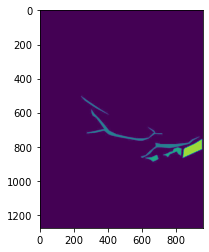

In [127]:
msk = Image.open('/home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_02bef207b833406d1922.jpg').convert('L')
plt.imshow(msk)

In [91]:
print(np.unique(msk))
print(np.shape(msk))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

### 4.2. Create color mask

In [4]:
from PIL import Image, ImageDraw
import numpy as np
import ast

# Function to generate masks for each image
def generate_masks(row):
    # Load the image
    image = Image.open(row['image_path']).convert("RGB")
#     print('image', np.shape(image))

    # Initialize an empty mask with alpha channel
    mask = Image.new("RGB", image.size, (0, 0, 0, 0))
#     print('mask', np.shape(mask))
    draw = ImageDraw.Draw(mask)

    # Convert the string representation of annotations to a list
    annotations = row['regions']

    # Map class names to unique identifiers
    class_mapping = {
        'rach': (255, 0, 0, 255),      # Red
        'vo_kinh': (0, 255, 0, 255),   # Green
        'be_den': (0, 0, 255, 255),    # Blue
        'mat_bo_phan': (255, 255, 0, 255),  # Yellow
        'tray_son': (255, 0, 255, 255),    # Magenta
        'mop_lom': (0, 255, 255, 255),     # Cyan
        'thung': (255, 255, 255, 255)      # White
    }

    # Draw each annotation on the mask using a unique color
    for annotation in ast.literal_eval(annotations):
        class_name = annotation['class']
        color = class_mapping.get(class_name, (0, 0, 0, 0))  # Default to transparent black

        # Extract x, y coordinates from the annotation
        all_x = annotation['all_x']
        all_y = annotation['all_y']

        # Convert list of coordinates to tuples
        points = list(zip(all_x, all_y))

        # Draw the polygon on the mask
        draw.polygon(points, fill=color)

    # Save the mask
    mask_path = f"/home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_{row['name']}"
    mask.save(mask_path)
    
    return mask_path

# Apply the function to generate masks for each image in the DataFrame
df_clean['mask_path'] = df_clean.apply(generate_masks, axis=1)

df_clean.to_csv('/home/shsingh/knowledge_distillation/Car_damage_detection/dataframes/df_clean_data_mask.csv')

In [5]:
# def get_mask_path(row):
#     img_path = row['image_path'].split
#     mask_path = f"/home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_{row['name']}"
    

# df_clean['mask_path'] = df_clean.apply()

In [6]:
df_clean

name  \
0                         01012020_172204image853193.jpg   
1                         01012020_172204image891741.jpg   
2                          01012020_172251image12370.jpg   
3                         01022020_083952image768902.jpg   
4                         01022020_102246image365727.jpg   
...                                                  ...   
11616  z2243796268779_2cadfc39a0bc5c92fa2b6d6560699ae...   
11617  z2246123119712_3cb5dbd5a8628e87dabe68e7f25c754...   
11618  z2247452590065_f564385937849ea15551c31edd6a841...   
11619  z2613326143146_1a2ac98d506eab5651d5a79a70cbd91...   
11620  z2669260231605_44c66996f57e4127d3b692ed7cf8c2d...   

                                                 regions  \
0      [{'all_x': [1, 30, 81, 79, 74, 65, 63, 65, 83,...   
1      [{'all_x': [-1, 2, 41, 107, 127, 179, 200, 233...   
2      [{'all_x': [220, 212, 213, 224, 241, 253, 262,...   
3      [{'all_x': [228, 224, 229, 237, 231], 'all_y':...   
4      [{'all_x': [897, 866, 853, 873, 927, 945, 958,...   
...                                                  ...   
11616  [{'all_x': [618, 686, 847, 858, 816, 717, 572,...   
11617  [{'all_x': [420, 431, 440, 448, 440, 426, 420,...   
11618  [{'all_x': [-2, 130, 320, 426, 501, 525, 541, ...   
11619  [{'all_x': [469, 533, 780, 883, 906, 975, 1023...   
11620  [{'all_x': [92, 2, 0, 51, 128, 183, 263, 378, ...   

                                              image_path  \
0      /home/shsingh/knowledge_distillation/Car_damag...   
1      /home/shsingh/knowledge_distillation/Car_damag...   
2      /home/shsingh/knowledge_distillation/Car_damag...   
3      /home/shsingh/knowledge_distillation/Car_damag...   
4      /home/shsingh/knowledge_distillation/Car_damag...   
...                                                  ...   
11616  /home/shsingh/knowledge_distillation/Car_damag...   
11617  /home/shsingh/knowledge_distillation/Car_damag...   
11618  /home/shsingh/knowledge_distillation/Car_damag...   
11619  /home/shsingh/knowledge_distillation/Car_damag...   
11620  /home/shsingh/knowledge_distillation/Car_damag...   

       total_damage_area_cv2  \
0                   156392.0   
1                   237672.5   
2                   224911.0   
3                   676724.0   
4                   662169.5   
...                      ...   
11616                70403.0   
11617              1201401.0   
11618                19887.5   
11619               223878.5   
11620               395520.0   

                                           regions_label  \
0      ['mat_bo_phan', 'rach', 'rach', 'mop_lom', 'tr...   
1        ['mat_bo_phan', 'rach', 'tray_son', 'tray_son']   
2      ['rach', 'mop_lom', 'tray_son', 'rach', 'rach'...   
3                                ['rach', 'mat_bo_phan']   
4      ['rach', 'tray_son', 'tray_son', 'tray_son', '...   
...                                                  ...   
11616                                 ['thung', 'thung']   
11617             ['thung', 'thung', 'rach', 'tray_son']   
11618                                        ['vo_kinh']   
11619                     ['mat_bo_phan', 'mat_bo_phan']   
11620                                    ['mat_bo_phan']   

                                               mask_path  
0      /home/shsingh/knowledge_distillation/Car_damag...  
1      /home/shsingh/knowledge_distillation/Car_damag...  
2      /home/shsingh/knowledge_distillation/Car_damag...  
3      /home/shsingh/knowledge_distillation/Car_damag...  
4      /home/shsingh/knowledge_distillation/Car_damag...  
...                                                  ...  
11616  /home/shsingh/knowledge_distillation/Car_damag...  
11617  /home/shsingh/knowledge_distillation/Car_damag...  
11618  /home/shsingh/knowledge_distillation/Car_damag...  
11619  /home/shsingh/knowledge_distillation/Car_damag...  
11620  /home/shsingh/knowledge_distillation/Car_damag...  

[11607 rows x 6 columns]

### 4.3. plot few samples w.r.t mask

### 4.3.1. Plot Image and Mask

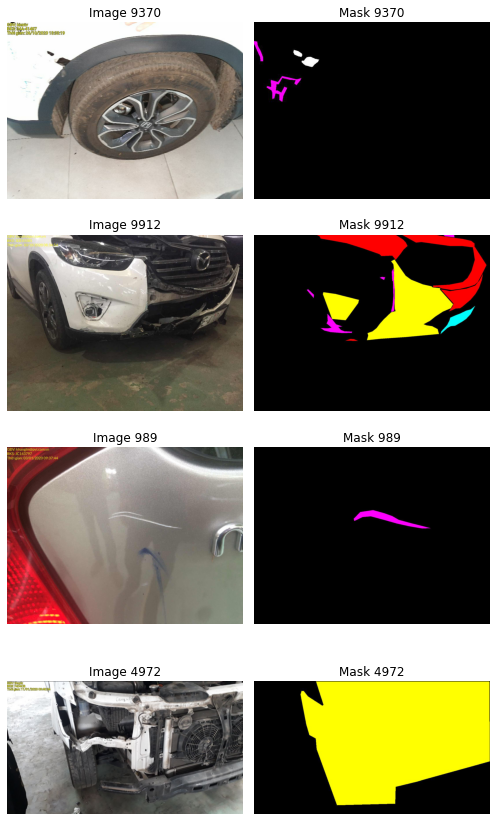

In [7]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Function to plot images and masks
def plot_images_with_masks(df, num_samples=4):
    # Randomly select 'num_samples' rows from the DataFrame
    selected_rows = random.sample(range(len(df)), num_samples)

    # Create a grid of subplots
    fig, axes = plt.subplots(num_samples, 2, figsize=(7, 3 * num_samples))

    for i, row_idx in enumerate(selected_rows):
        # Load and display the image
        image_path = df.iloc[row_idx]['image_path']
        img = Image.open(image_path).convert("RGB")
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Image {row_idx + 1}")

        # Load and display the mask
        mask_path = df.iloc[row_idx]['mask_path']
        mask = Image.open(mask_path).convert("RGBA")
        axes[i, 1].imshow(mask)
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Mask {row_idx + 1}")

    plt.tight_layout()
    plt.show()

# Plot images with masks
plot_images_with_masks(df_clean)


### 4.3.2. Plot Image + mask + superimosed(image over mask)

image: (600, 1066, 3)
image: (600, 800, 3)
image: (1512, 2016, 3)
image: (600, 800, 3)


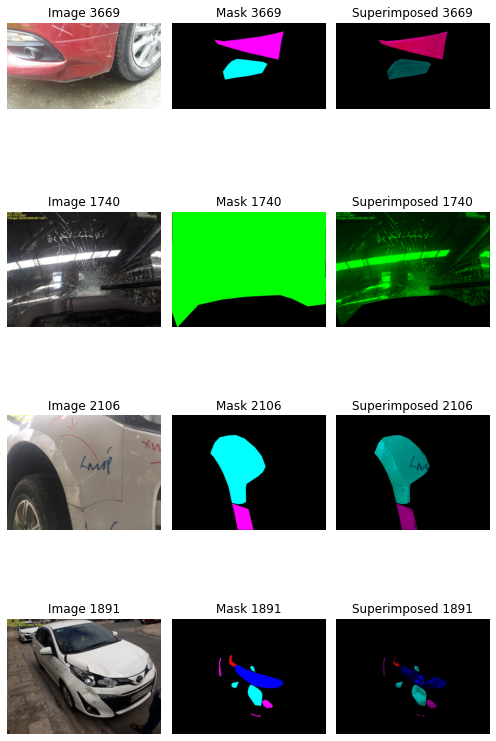

In [8]:
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageChops

# Function to plot images, masks, and superimposed images
def plot_images_with_masks(df, num_samples=4):
    # Randomly select 'num_samples' rows from the DataFrame
    selected_rows = random.sample(range(len(df)), num_samples)

    # Create a grid of subplots
    fig, axes = plt.subplots(num_samples, 3, figsize=(7, 3 * num_samples))

    for i, row_idx in enumerate(selected_rows):
        # Load and display the image
        image_path = df.iloc[row_idx]['image_path']
        img = Image.open(image_path).convert("RGB")
        print('image:', np.shape(img))
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Image {row_idx + 1}")

        # Load and display the mask
        mask_path = df.iloc[row_idx]['mask_path']
        mask = Image.open(mask_path).convert("RGB")
        axes[i, 1].imshow(mask)
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Mask {row_idx + 1}")

        # Superimpose the image and mask
        superimposed_image = ImageChops.multiply( mask, img)
        axes[i, 2].imshow(superimposed_image)
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f"Superimposed {row_idx + 1}")

    plt.tight_layout()
    plt.show()

# Plot images with masks and superimposed images
plot_images_with_masks(df_clean)


### 4.3.3. Plot Image + Mask + Superimposed(mask over image)

alpha: (960, 1280, 3)
alpha: (1512, 2016, 3)
alpha: (600, 1066, 3)
alpha: (600, 1066, 3)


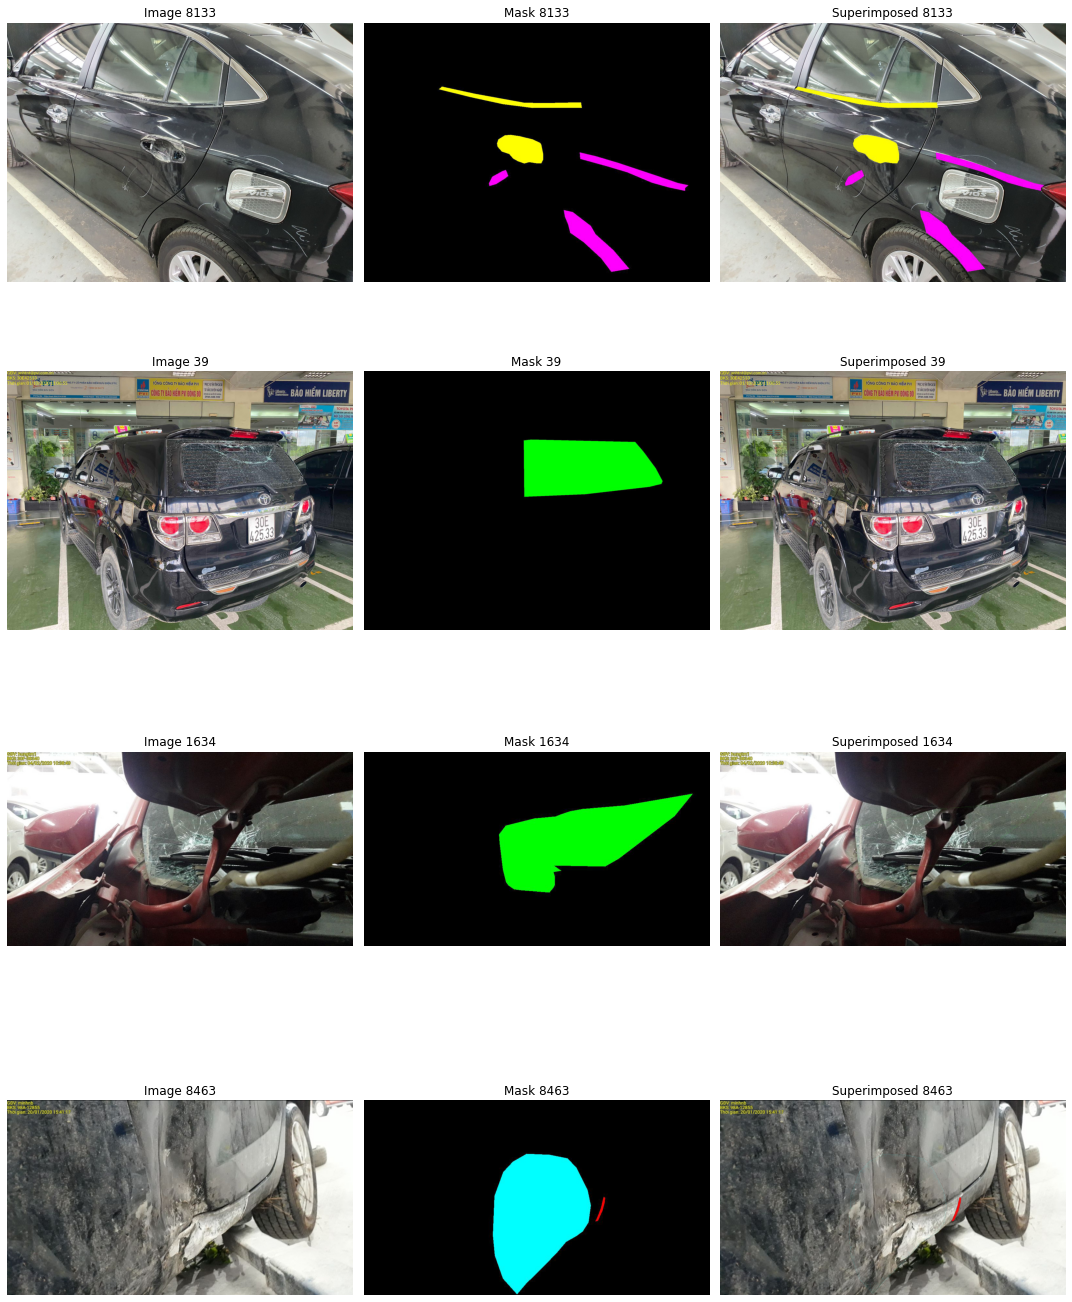

In [9]:
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image

# Function to resize and superimpose mask over the original image
def superimpose_mask(image, mask):
    # Resize mask to match the original image size
    mask = mask.resize(image.size)

    # Convert the mask to a 3-channel RGBA image
    alpha = np.array(mask)[:, :, 0]
    alpha = alpha / 255.0  # Normalize alpha values
    alpha = np.expand_dims(alpha, axis=2)
    alpha = np.repeat(alpha, 3, axis=2)
    print('alpha:', np.shape(alpha))

    # Blend the original image and the mask
    superimposed = np.array(image) * (1 - alpha) + np.array(mask) * alpha

    return Image.fromarray(superimposed.astype('uint8'))

# Function to plot images, masks, and superimposed images
def plot_images_with_masks_and_superimposed(df, num_samples=4):
    # Randomly select 'num_samples' rows from the DataFrame
    selected_rows = random.sample(range(len(df)), num_samples)

    # Create a grid of subplots
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    for i, row_idx in enumerate(selected_rows):
        # Load and display the image
        image_path = df.iloc[row_idx]['image_path']
        img = Image.open(image_path).convert("RGB")
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Image {row_idx + 1}")

        # Load and display the mask
        mask_path = df.iloc[row_idx]['mask_path']
        mask = Image.open(mask_path).convert("RGB")
        axes[i, 1].imshow(mask)
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Mask {row_idx + 1}")

        # Superimpose mask on the original image
        superimposed_img = superimpose_mask(img, mask)
        axes[i, 2].imshow(superimposed_img)
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f"Superimposed {row_idx + 1}")

    plt.tight_layout()
    plt.show()

# Plot images with masks and superimposed images
plot_images_with_masks_and_superimposed(df_clean)


# SEGMENTATION

# A. Prepare Splits:


In [56]:
data_df = pd.read_csv('/home/shsingh/knowledge_distillation/Car_damage_detection/dataframes/df_clean_subset.csv',index_col=0)
data_df

name  \
0          28082020_112302image127996.jpg   
1     e2eee407012020_083714image63596.jpg   
2          26102020_090300image153423.jpg   
3          03012020_110803image351004.jpg   
4          20012020_105624image769407.jpg   
...                                   ...   
5799       12032020_102738image175213.jpg   
5800       06012020_110941image401552.jpg   
5801       13012020_145400image553845.jpg   
5802       02012020_110416image311725.jpg   
5803       09112020_104532image472148.jpg   

                                                regions  \
0     [{'all_x': [152, 207, 236, 272, 323, 384, 454,...   
1     [{'all_x': [765, 743, 795, 839, 842], 'all_y':...   
2     [{'all_x': [855, 842, 853, 907, 937, 994, 1074...   
3     [{'all_x': [1097, 1379, 1626, 1628, 1113, 1103...   
4     [{'all_x': [900, 917, 931, 933, 925, 913, 960,...   
...                                                 ...   
5799  [{'all_x': [2, 95, 218, 378, 516, 599, 683, 69...   
5800  [{'all_x': [1476, 1482, 1510, 1584, 1689, 1738...   
5801  [{'all_x': [263, 281, 325, 295, 256], 'all_y':...   
5802  [{'all_x': [455, 466, 473, 487, 558, 552, 526,...   
5803  [{'all_x': [1638, 1675, 1665, 1676, 1695, 1682...   

                                             image_path  \
0     /home/shsingh/knowledge_distillation/Car_damag...   
1     /home/shsingh/knowledge_distillation/Car_damag...   
2     /home/shsingh/knowledge_distillation/Car_damag...   
3     /home/shsingh/knowledge_distillation/Car_damag...   
4     /home/shsingh/knowledge_distillation/Car_damag...   
...                                                 ...   
5799  /home/shsingh/knowledge_distillation/Car_damag...   
5800  /home/shsingh/knowledge_distillation/Car_damag...   
5801  /home/shsingh/knowledge_distillation/Car_damag...   
5802  /home/shsingh/knowledge_distillation/Car_damag...   
5803  /home/shsingh/knowledge_distillation/Car_damag...   

      total_damage_area_cv2  \
0                    6761.5   
1                   47235.5   
2                  263957.5   
3                   28707.0   
4                  137119.5   
...                     ...   
5799               270991.5   
5800                15712.0   
5801                 2828.0   
5802                42983.5   
5803                 1713.0   

                                          regions_label  \
0                                     ['rach', 'thung']   
1                              ['tray_son', 'tray_son']   
2                                ['tray_son', 'be_den']   
3                              ['tray_son', 'tray_son']   
4     ['rach', 'tray_son', 'mat_bo_phan', 'mop_lom',...   
...                                                 ...   
5799                                        ['vo_kinh']   
5800                                        ['mop_lom']   
5801                                   ['rach', 'rach']   
5802                         ['mop_lom', 'mat_bo_phan']   
5803                                        ['vo_kinh']   

                                              mask_path  
0     /home/shsingh/knowledge_distillation/Car_damag...  
1     /home/shsingh/knowledge_distillation/Car_damag...  
2     /home/shsingh/knowledge_distillation/Car_damag...  
3     /home/shsingh/knowledge_distillation/Car_damag...  
4     /home/shsingh/knowledge_distillation/Car_damag...  
...                                                 ...  
5799  /home/shsingh/knowledge_distillation/Car_damag...  
5800  /home/shsingh/knowledge_distillation/Car_damag...  
5801  /home/shsingh/knowledge_distillation/Car_damag...  
5802  /home/shsingh/knowledge_distillation/Car_damag...  
5803  /home/shsingh/knowledge_distillation/Car_damag...  

[5804 rows x 6 columns]

In [58]:
data_df = data_df.sample(frac=1).reset_index(drop=True)
data_df.head()

name  \
0  27102020_083311image996859.jpg   
1  20102020_082306image908946.jpg   
2  24112020_151230image780945.jpg   
3  06012020_103315image151734.jpg   
4  20012020_090726image998827.jpg   

                                             regions  \
0  [{'all_x': [647, 666, 692, 750, 795, 838, 894,...   
1  [{'all_x': [1177, 1151, 1145, 1141, 1175, 1191...   
2  [{'all_x': [244, 236, 253, 280, 293, 320, 329,...   
3  [{'all_x': [834, 787, 773, 791, 856, 896, 893]...   
4  [{'all_x': [317, 299, 303, 312, 346, 381, 442,...   

                                          image_path  total_damage_area_cv2  \
0  /home/shsingh/knowledge_distillation/Car_damag...               140603.0   
1  /home/shsingh/knowledge_distillation/Car_damag...               802595.5   
2  /home/shsingh/knowledge_distillation/Car_damag...               150494.5   
3  /home/shsingh/knowledge_distillation/Car_damag...                18203.0   
4  /home/shsingh/knowledge_distillation/Car_damag...                16952.5   

                                       regions_label  \
0                              ['be_den', 'mop_lom']   
1  ['thung', 'tray_son', 'tray_son', 'tray_son', ...   
2  ['thung', 'rach', 'mop_lom', 'tray_son', 'mop_...   
3                 ['mop_lom', 'mop_lom', 'tray_son']   
4                                        ['mop_lom']   

                                           mask_path  
0  /home/shsingh/knowledge_distillation/Car_damag...  
1  /home/shsingh/knowledge_distillation/Car_damag...  
2  /home/shsingh/knowledge_distillation/Car_damag...  
3  /home/shsingh/knowledge_distillation/Car_damag...  
4  /home/shsingh/knowledge_distillation/Car_damag...

In [59]:
from sklearn.model_selection import train_test_split

# Assume df_clean contains 'image_path' and 'mask_path' columns
# Split the data into train and validation sets
train_df, val_df = train_test_split(data_df, test_size=0.2, random_state=42)

# Check data distribution in train and validation sets
print("Train Set:")
print(len(train_df['regions_label'].value_counts()))

print("\nValidation Set:")
print(len(val_df['regions_label'].value_counts()))


Train Set:
980

Validation Set:
331


### A.1 Calculate mean and std train_df

In [143]:
# Initialize lists to store channel-wise means and standard deviations
means = []
stds = []
mask_means=[]
mask_std = []

# Iterate through the dataset to compute means and standard deviations
for sample in train_dataset:
    img = sample['image']  # Assuming 'image' is the key for the image data in your dataset
    means.append(np.mean(img.numpy(), axis=(1, 2)))
    stds.append(np.std(img.numpy(), axis=(1, 2)))

# Compute the overall mean and standard deviation
overall_mean = np.mean(means, axis=0)
overall_std = np.mean(stds, axis=0)

print("Overall Mean: ", overall_mean)
print("Overall Std: ", overall_std)

for sample in train_dataset:
    img = sample['mask']  # Assuming 'image' is the key for the image data in your dataset
    mask_means.append(np.mean(img.numpy(), axis=(1, 2)))
    mask_std.append(np.std(img.numpy(), axis=(1, 2)))

# Compute the overall mean and standard deviation
overall_mean_mask = np.mean(mask_means, axis=0)
overall_std_mask = np.mean(mask_std, axis=0)

print("Overall Mean: ", overall_mean_mask)
print("Overall Std: ", overall_std_mask)

KeyboardInterrupt: 

# B. Custom DataLoader

In [156]:
# class CustomDataset(Dataset):
#     def __init__(self, dataframe, transform=None):
#         self.dataframe = dataframe
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         img_path = self.dataframe.iloc[idx]['image_path']
#         mask_path = self.dataframe.iloc[idx]['mask_path']

#         # Load the image and mask
#         image = Image.open(img_path).convert("RGB")
#         mask = Image.open(mask_path).convert("RGB")

#         # Apply data augmentation if specified
#         if self.transform:
#             # Convert to PIL images
#             image = self.transform['image'](image)
#             mask = self.transform['mask'](mask)

#         return {'image': image, 'mask': mask}
    
    
    
    
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.data_transform = transform

    def __len__(self):
        return len(self.dataframe)

    def label_encode_mask(self, mask_rgb):
        class_mapping = {
            (255, 0, 0): 0,    # 'rach'
            (0, 255, 0): 1,    # 'vo_kinh'
            (0, 0, 255): 2,    # 'be_den'
            (255, 255, 0): 3,  # 'mat_bo_phan'
            (255, 0, 255): 4,  # 'tray_son'
            (0, 255, 255): 5,  # 'mop_lom'
            (255, 255, 255): 6  # 'thung'
        }
        # Convert RGB values to tuple for dictionary lookup
        pixel_value = tuple(mask_rgb.getpixel((0, 0))[:3])
        # Use the class mapping to get the label
        label = class_mapping.get(pixel_value, 0)  # Default to 0 for unknown
        # Create a tensor where each channel represents a different class
        encoded_mask = torch.zeros(len(class_mapping), mask_rgb.size[0], mask_rgb.size[1])
        encoded_mask[label, :, :] = 1.0
        return encoded_mask

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        mask_path = self.dataframe.iloc[idx]['mask_path']
        image = Image.open(img_path).convert("RGB").resize((256, 256))
        mask = Image.open(mask_path).convert("RGBA")
        # Only use RGB channels (discard the alpha channel)
        mask_rgb = mask.convert("RGB").resize((256, 256))
        # Encode the mask
        encoded_mask = self.label_encode_mask(mask_rgb)
        if self.data_transform:
            image = self.data_transform['image'](image)
#             encoded_mask = self.data_transform['mask'](encoded_mask)
        return {'image': image, 'mask': encoded_mask}

# Define data transformations
transform = {
    'image': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)], p=0.5),
        transforms.RandomRotation(degrees=[0,120]),
        transforms.ToTensor()
    ]),
    'mask': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=[0, 120]),
        transforms.ToTensor()
    ])
}

# Create custom datasets and dataloaders
train_dataset = CustomDataset(train_df, transform=transform)
val_dataset = CustomDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [1]:
# import matplotlib.pyplot as plt
# import torchvision.transforms.functional as TF

# # Function to display images and masks
# def show_images_masks(images, masks, title='Images and Masks'):
#     num_samples = len(images)
#     fig, axes = plt.subplots(num_samples, 2, figsize=(8, 4 * num_samples))

#     for i in range(num_samples):
#         # Display image
#         image = TF.to_pil_image(images[i]).convert("RGB")
#         axes[i, 0].imshow(image)
#         axes[i, 0].axis('off')
#         axes[i, 0].set_title(f"Image {i + 1}")

#         # Display mask
#         mask = TF.to_pil_image(masks[i]).convert("RGB")
#         axes[i, 1].imshow(mask, cmap='gray')
#         axes[i, 1].axis('off')
#         axes[i, 1].set_title(f"Mask {i + 1}")

#     plt.tight_layout()
#     plt.suptitle(title, y=1.02, fontsize=16)
#     plt.show()

# # Iterate through the dataloader
# for batch in train_loader:
# #     print(batch)
#     images = batch['image']
#     masks = batch['mask']

#     # Display images and masks
#     show_images_masks(images, masks, title='Images and Masks')

#     # Break after displaying one batch (remove this line if you want to continue displaying more batches)
#     break


# C. Visualize the train_loader

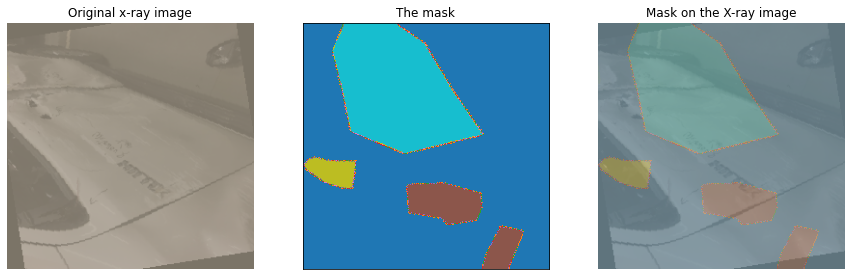

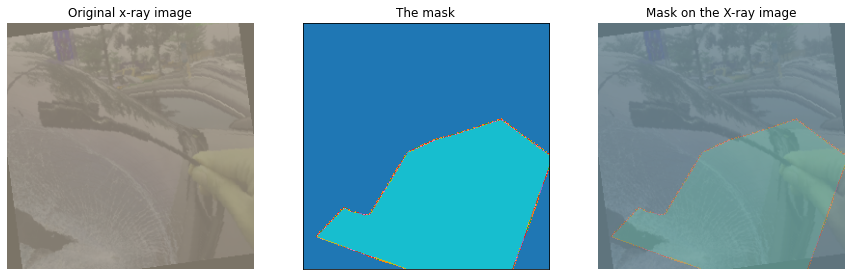

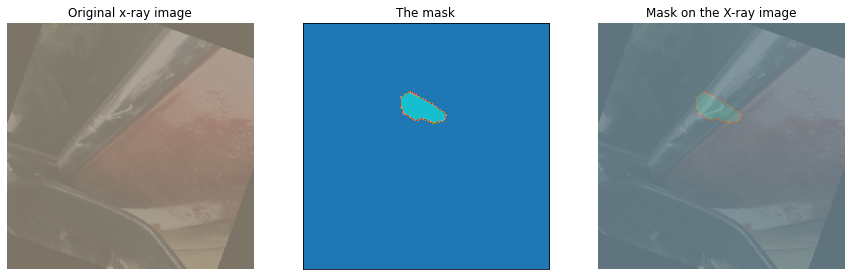

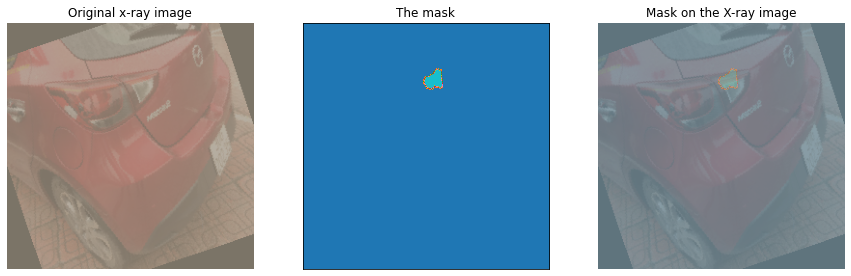

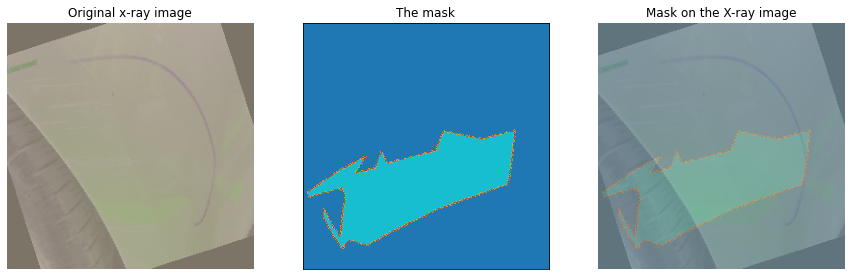

In [57]:
def denoramlize(img):
    img = img.permute(1,2,0)            # change shape ---> (width, height, channel)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    img = img*std + mean
    img = np.clip(img,0,1)              # convert the pixel values range(min=0, max=1)
    return img

def imshow(img, mask):
    fig = plt.figure(figsize=(15, 10))
    a = fig.add_subplot(1, 3, 1)
    plt.imshow(denoramlize(img), cmap='bone')
    a.set_title("Original x-ray image")
    plt.grid(False)
    plt.axis("off")

    a = fig.add_subplot(1, 3, 2)
    imgplot = plt.imshow(torch.squeeze(mask, dim=1).permute(1,2,0), cmap='tab10')
    a.set_title("The mask")
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    a = fig.add_subplot(1, 3, 3)
    plt.imshow(denoramlize(img), cmap='bone')
    plt.imshow(torch.squeeze(mask, dim=1).permute(1,2,0), cmap='tab10', alpha=0.3)
    a.set_title("Mask on the X-ray image")

    plt.axis("off")
    plt.grid(False)


def show_batch_image(dataloader, num_images):
    data = next(iter(dataloader))
    image,mask = data['image'],data['mask']
    img_idx = torch.randint(0, dataloader.batch_size, (num_images,))
    for i in img_idx:
        imshow(image[i], mask[i])

show_batch_image(train_loader, 5)

# C. MODEL

In [64]:

from sklearn import model_selection
import segmentation_models_pytorch as smp
from sklearn.metrics import jaccard_score

In [33]:
torchvision.__version__

'0.15.0'

In [26]:
model_list=['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x4d', 'resnext101_32x8d', 'resnext101_32x16d', 'resnext101_32x32d', 'resnext101_32x48d', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn107', 'dpn131', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'inceptionresnetv2', 'inceptionv4', 'efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 'efficientnet-b3', 'efficientnet-b4', 'efficientnet-b5', 'efficientnet-b6', 'efficientnet-b7', 'mobilenet_v2', 'xception', 'timm-efficientnet-b0', 'timm-efficientnet-b1', 'timm-efficientnet-b2', 'timm-efficientnet-b3', 'timm-efficientnet-b4', 'timm-efficientnet-b5', 'timm-efficientnet-b6', 'timm-efficientnet-b7', 'timm-efficientnet-b8', 'timm-efficientnet-l2', 'timm-tf_efficientnet_lite0', 'timm-tf_efficientnet_lite1', 'timm-tf_efficientnet_lite2', 'timm-tf_efficientnet_lite3', 'timm-tf_efficientnet_lite4', 'timm-resnest14d', 'timm-resnest26d', 'timm-resnest50d', 'timm-resnest101e', 'timm-resnest200e', 'timm-resnest269e', 'timm-resnest50d_4s2x40d', 'timm-resnest50d_1s4x24d', 'timm-res2net50_26w_4s', 'timm-res2net101_26w_4s', 'timm-res2net50_26w_6s', 'timm-res2net50_26w_8s', 'timm-res2net50_48w_2s', 'timm-res2net50_14w_8s', 'timm-res2next50', 'timm-regnetx_002', 'timm-regnetx_004', 'timm-regnetx_006', 'timm-regnetx_008', 'timm-regnetx_016', 'timm-regnetx_032', 'timm-regnetx_040', 'timm-regnetx_064', 'timm-regnetx_080', 'timm-regnetx_120', 'timm-regnetx_160', 'timm-regnetx_320', 'timm-regnety_002', 'timm-regnety_004', 'timm-regnety_006', 'timm-regnety_008', 'timm-regnety_016', 'timm-regnety_032', 'timm-regnety_040', 'timm-regnety_064', 'timm-regnety_080', 'timm-regnety_120', 'timm-regnety_160', 'timm-regnety_320', 'timm-skresnet18', 'timm-skresnet34', 'timm-skresnext50_32x4d', 'timm-mobilenetv3_large_075', 'timm-mobilenetv3_large_100', 'timm-mobilenetv3_large_minimal_100', 'timm-mobilenetv3_small_075', 'timm-mobilenetv3_small_100', 'timm-mobilenetv3_small_minimal_100', 'timm-gernet_s', 'timm-gernet_m', 'timm-gernet_l', 'mit_b0', 'mit_b1', 'mit_b2', 'mit_b3', 'mit_b4', 'mit_b5', 'mobileone_s0', 'mobileone_s1', 'mobileone_s2', 'mobileone_s3', 'mobileone_s4']

In [29]:
for m in model_list:
    try:
        model = smp.Unet(
        encoder_name=model_list,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=7,                      # model output channels (number of classes in your dataset)
        )
        print(m)
    except:
        continue

resnet18


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/shsingh/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/shsingh/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


resnet101


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/shsingh/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /home/shsingh/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /home/shsingh/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth
Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/dpn68-4af7d88d2.pth" to /home/shsingh/.cache/torch/hub/checkpoints/dpn68-4af7d88d2.pth
Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/dpn98-722954780.pth" to /home/shsingh/.cache/torch/hub/checkpoints/dpn98-722954780.pth
Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/dpn131-7af84be88.pth" to /home/shsingh/.cache/torch/hub/checkpoints/dpn131-7af84be88.pth
Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /home/shsingh/.cache/torch/hub/chec

mobilenet_v2


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to /home/shsingh/.cache/torch/hub/checkpoints/xception-43020ad28.pth
Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /home/shsingh/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b1-5c1377c4.pth" to /home/shsingh/.cache/torch/hub/checkpoints/tf_efficientnet_b1-5c1377c4.pth
Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b2-e393ef04.pth" to /home/shsingh/.cache/torch/hub/checkpoints/tf_efficientnet_b2-e393ef04.pth
Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b3-e3bd6955.pth" to /home/shsingh/.cache/torch/hub/checkpoints/tf_efficientnet_b3-e3bd6955.pth
Downloading: "htt

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_320-8ea38b93.pth" to /home/shsingh/.cache/torch/hub/checkpoints/regnetx_320-8ea38b93.pth
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_002-e68ca334.pth" to /home/shsingh/.cache/torch/hub/checkpoints/regnety_002-e68ca334.pth
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_004-0db870e6.pth" to /home/shsingh/.cache/torch/hub/checkpoints/regnety_004-0db870e6.pth
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_006-c67e57ec.pth" to /home/shsingh/.cache/torch/hub/checkpoints/regnety_006-c67e57ec.pth
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_008-dc900dbe.pth" to /home/shsingh/.cache/torch/hub/checkpoints/regnety_008-dc900dbe.pth
Downloading: "https://github.com/rwightman/py

In [63]:

model = smp.Unet(
    encoder_name = 'mobilenet_v2',
    encoder_weights = 'imagenet',
    in_channels = 3,
    classes = 7,
    activation = None
)
print(model)

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [159]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the specified device
model = model.to(device)

# D. TRAINIG UNet:

### D.1. Custom loss fucntion & evaluation metric
> 1. Dice Loss
> 2. IoU

In [189]:
# # Define Dice Loss
# class DiceLoss(nn.Module):
#     def __init__(self):
#         super(DiceLoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):
#         intersection = (inputs * targets).sum(dim=(2, 3))
#         union = inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
#         dice = (2. * intersection + smooth) / (union + smooth)
#         return 1 - dice.mean()

# Define IoU metric
# def calculate_iou(outputs, targets):
#     intersection = torch.logical_and(outputs, targets).sum(dim=(2, 3))
#     union = torch.logical_or(outputs, targets).sum(dim=(2, 3))
#     iou = (intersection / union).mean()
#     return iou.item()

class DiceLoss(nn.Module):
    def __init__(self, num_classes):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes

    def forward(self, inputs, targets, smooth=1):
        loss = 0

        for class_idx in range(self.num_classes):
            class_inputs = inputs[:, class_idx, :, :]
            class_targets = targets[:, class_idx, :, :]

            intersection = (class_inputs * class_targets).sum(dim=(1, 2))
            union = class_inputs.sum(dim=(1, 2)) + class_targets.sum(dim=(1, 2))
            class_dice = (2. * intersection + smooth) / (union + smooth)

            loss += 1 - class_dice.mean()

        return loss / self.num_classes


# def calculate_iou(outputs, targets, num_classes):
#     intersection = torch.logical_and(outputs, targets).sum(dim=(2, 3))
#     union = torch.logical_or(outputs, targets).sum(dim=(2, 3))
    
#     class_iou = torch.zeros(num_classes).to(outputs.device)
    
#     for class_idx in range(num_classes):
#         class_intersection = intersection[:, class_idx]
#         class_union = union[:, class_idx]
        
#         class_iou[class_idx] = (class_intersection / class_union).mean()

#     mean_iou = class_iou.mean()
#     return mean_iou.item()


# def calculate_iou(outputs, targets, num_classes, epsilon=1e-8):
#     intersection = torch.logical_and(outputs, targets).sum(dim=(2, 3))
#     union = torch.logical_or(outputs, targets).sum(dim=(2, 3))
    
#     class_iou = torch.zeros(num_classes).to(outputs.device)
    
#     for class_idx in range(num_classes):
#         class_intersection = intersection[:, class_idx]
#         class_union = union[:, class_idx]
        
#         # Add epsilon to avoid division by zero
#         class_iou[class_idx] = (class_intersection + epsilon) / (class_union + epsilon)

#     mean_iou = class_iou.mean()
#     return mean_iou.item()



# def calculate_iou(outputs, targets, num_classes, epsilon=1e-8):
#     intersection = torch.logical_and(outputs.bool(), targets.bool()).sum(dim=(2, 3))
#     union = torch.logical_or(outputs.bool(), targets.bool()).sum(dim=(2, 3))
    
#     # Add epsilon to avoid division by zero
#     iou_per_class = (intersection.float() + epsilon) / (union.float() + epsilon)

#     # Handle the case when union is zero
#     iou_per_class[union == 0] = 0

#     mean_iou = iou_per_class.mean()
#     return mean_iou.item()

def calculate_iou(pred, target, num_classes):
    ious = []

    for cls in range(num_classes):
        pred_inds = pred[:, cls, :, :] == 1
        target_inds = target[:, cls, :, :] == 1
        intersection = (pred_inds[target_inds]).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item() - intersection

        if union == 0:
            ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        else:
            ious.append(float(intersection) / float(max(union, 1)))

    return np.array(ious)



num_classes = 7  # Adjust based on your dataset
dice_loss = DiceLoss(num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1

### D.2. Confiure segmentation model

In [13]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

### D.3. training loop

In [191]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_iou = 0.0

    for batch in tqdm(train_loader):
        inputs = batch['image'].to(device)
        masks = batch['mask'].to(device)
        print('inputs',inputs.shape)
        print('masks',masks.shape)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        print('outputs',outputs.shape)
        
        loss = dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate IoU
        outputs_binary = (outputs > 0.2).float()  # Adjust threshold if needed
        iou = calculate_iou(outputs_binary, masks, num_classes=7)  # Assuming 7 classes
        running_iou += iou

    average_train_loss = running_loss / len(train_loader)
    average_train_iou = running_iou / len(train_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_train_loss}, Training IoU: {average_train_iou}")

    # Validation loop
    model.eval()
    val_running_loss = 0.0
    val_running_iou = 0.0

    with torch.no_grad():
        for val_batch in tqdm(val_loader):
            val_inputs = val_batch['image'].to(device)
            val_masks = val_batch['mask'].to(device)

            val_outputs = model(val_inputs)
            val_loss = dice_loss(val_outputs, val_masks)

            val_running_loss += val_loss.item()

            # Calculate IoU
            val_outputs_binary = (val_outputs > 0.5).float()
            val_iou = calculate_iou(val_outputs_binary, val_masks, num_classes=7)
            val_running_iou += val_iou

    average_val_loss = val_running_loss / len(val_loader)
    average_val_iou = val_running_iou / len(val_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {average_val_loss}, Validation IoU: {average_val_iou}")

    # Additional validation metrics can be included here


  1%|          | 1/146 [00:03<08:26,  3.49s/it]

inputs torch.Size([32, 3, 256, 256])
masks torch.Size([32, 7, 256, 256])
outputs torch.Size([32, 7, 256, 256])


  1%|▏         | 2/146 [00:03<03:44,  1.56s/it]

inputs torch.Size([32, 3, 256, 256])
masks torch.Size([32, 7, 256, 256])
outputs torch.Size([32, 7, 256, 256])


  1%|▏         | 2/146 [00:05<06:35,  2.74s/it]


KeyboardInterrupt: 

# E. Evaluation 

## KAGLE TEST_SET

In [79]:
# Assuming your JSON file is named 'your_file.json'
json_file_path_test = '/home/shsingh/knowledge_distillation/Car_damage_detection/0Val_via_annos.json'

def get_image_path(x):
    image_root_path = '/home/shsingh/knowledge_distillation/Car_damage_detection/validation/validation'
    return f'{image_root_path}/{x}'

import cv2
def find_corrupt_images(image_paths_column):
    corrupt_images = []
    for image_path in image_paths_column:
        try:
            img = Image.open(image_path).convert('RGB')
        except (OSError, IOError) as e:
            print(f"Error loading image {image_path}: {e}")
            corrupt_images.append(image_path)
    return corrupt_images

# Function to calculate area from polygon coordinates
def calculate_polygon_area(all_x, all_y):
    points = np.array(list(zip(all_x, all_y)), dtype=np.int32)
    points = points.reshape((-1, 1, 2))
    area = cv2.contourArea(points)
    return area

def get_region_class(x):
    return [region['class'] for region in x]

# Load JSON file into a DataFrame
df_test = pd.read_json(json_file_path_test)
df_test = df_test.T.reset_index(drop=True)
df_test['image_path'] = df_test['name'].apply(lambda x: get_image_path(x))
# df_test

# Create a new column for total damaged area
df_test['total_damage_area_cv2'] = df_test['regions'].apply(lambda x: sum(calculate_polygon_area(entry['all_x'], entry['all_y']) for entry in x))
df_test['regions_label'] =df_test['regions'].apply(get_region_class)
# df_test

# Assuming df is your DataFrame and 'image_path' is the column containing image paths
corrupt_images_list_test = find_corrupt_images(df_test['image_path'])
print("Corrupt Images:")




# Filter out rows corresponding to corrupt images
df_test_clean = df_test[~df_test['image_path'].isin(corrupt_images_list_test)]
df_test_clean = df_test_clean.reset_index(drop=True)
# df_test_clean.to_csv('/home/shsingh/knowledge_distillation/Car_damage_detection/dataframes/df_test_clean_data.csv')

df_test_clean

Error loading image /home/shsingh/knowledge_distillation/Car_damage_detection/validation/validation/24032020_094730image64439.jpg: image file is truncated (0 bytes not processed)
Error loading image /home/shsingh/knowledge_distillation/Car_damage_detection/validation/validation/24032020_140438image435324.jpg: image file is truncated (82 bytes not processed)
Corrupt Images:


name  \
0                        01022020_104459image894113.jpg   
1                        01022020_104510image892040.jpg   
2                        01022020_153342image229797.jpg   
3                         01042020_091351image21145.jpg   
4                        01092020_102550image661127.jpg   
...                                                 ...   
2317  z2217852378628_1a6eaa0c666e9bd70d809f01362e4e2...   
2318  z2232529920092_cf4f223ec02d627134c25f741acbbc9...   
2319  z2275245000309_276c103aab519eeb31d6f731b9b0e8b...   
2320  z2613326154641_3d42f55f8609612f4dc791ca20b7224...   
2321  z2669260203920_ce716d85dc20a3ad920f88bf0a0dfcd...   

                                                regions  \
0     [{'all_x': [894, 933, 953, 986, 989, 1009, 103...   
1     [{'all_x': [781, 893, 1015, 1128, 1148, 1152, ...   
2     [{'all_x': [1071, 1106, 1154, 1179, 1178, 1150...   
3     [{'all_x': [-1, 139, 292, 426, 557, 703, 800, ...   
4     [{'all_x': [294, 308, 323, 334, 338, 324, 323,...   
...                                                 ...   
2317  [{'all_x': [77, 66, 73, 87, 108, 145, 193, 228...   
2318  [{'all_x': [586, 1, 0, 109, 197, 335, 665, 114...   
2319  [{'all_x': [115, 152, 181, 414, 570, 581, 605,...   
2320  [{'all_x': [991, 990, 983, 939, 919, 903, 882,...   
2321  [{'all_x': [930, 965, 1027, 1092, 1144, 1174, ...   

                                             image_path  \
0     /home/shsingh/knowledge_distillation/Car_damag...   
1     /home/shsingh/knowledge_distillation/Car_damag...   
2     /home/shsingh/knowledge_distillation/Car_damag...   
3     /home/shsingh/knowledge_distillation/Car_damag...   
4     /home/shsingh/knowledge_distillation/Car_damag...   
...                                                 ...   
2317  /home/shsingh/knowledge_distillation/Car_damag...   
2318  /home/shsingh/knowledge_distillation/Car_damag...   
2319  /home/shsingh/knowledge_distillation/Car_damag...   
2320  /home/shsingh/knowledge_distillation/Car_damag...   
2321  /home/shsingh/knowledge_distillation/Car_damag...   

      total_damage_area_cv2                                      regions_label  
0                   95891.0                             [rach, rach, tray_son]  
1                  111327.5                             [rach, rach, tray_son]  
2                 1124677.5                             [vo_kinh, mat_bo_phan]  
3                  349987.5                                          [vo_kinh]  
4                   87026.5        [thung, thung, tray_son, tray_son, mop_lom]  
...                     ...                                                ...  
2317               100708.5  [rach, rach, thung, rach, tray_son, tray_son, ...  
2318               900671.0                                          [vo_kinh]  
2319               490400.0                         [mat_bo_phan, mat_bo_phan]  
2320               452347.5  [mat_bo_phan, mop_lom, mat_bo_phan, mat_bo_pha...  
2321               331008.5                                      [mat_bo_phan]  

[2322 rows x 5 columns]

In [81]:
df_test_clean.to_csv('/home/shsingh/knowledge_distillation/Car_damage_detection/dataframes/df_test_clean_data.csv')

In [96]:
len(corrupt_images_list_test)

2

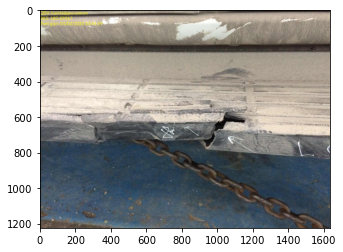

In [97]:
test = Image.open(df_test['image_path'][0])
plt.imshow(test)

In [ ]:
class TestCustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        # Load the image and mask
        image = Image.open(img_path).convert("RGB")
        # Apply data augmentation if specified
        if self.transform:
            # Convert to PIL images
            image = self.transform['image'](image)
        return image

## ROUGH work

In [ ]:
def generate_masks(row):
    # Load the image
    image = Image.open(row['image_path']).convert("RGB")

    # Initialize an empty mask with alpha channel
    mask = Image.new("RGB", image.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(mask)

    # Convert the string representation of annotations to a list
    annotations = row['regions']

    # Map class names to unique identifiers
    class_mapping = {
        'rach': (255, 0, 0, 255),      # Red
        'vo_kinh': (0, 255, 0, 255),   # Green
        'be_den': (0, 0, 255, 255),    # Blue
        'mat_bo_phan': (255, 255, 0, 255),  # Yellow
        'tray_son': (255, 0, 255, 255),    # Magenta
        'mop_lom': (0, 255, 255, 255),     # Cyan
        'thung': (255, 255, 255, 255)      # White
    }

    # Create a mapping from color to class label
    color_to_label = {v: k for k, v in class_mapping.items()}

    # Iterate over each pixel in the mask and perform label encoding
    for x in range(image.width):
        for y in range(image.height):
            pixel_color = image.getpixel((x, y))
            class_name = color_to_label.get(pixel_color, 'background')
            class_id = class_mapping.get(class_name, (0, 0, 0, 0))  # Default to transparent black

            # Draw the pixel on the mask
            draw.point((x, y), fill=class_id)

    # Save the mask
    mask_path = f"/home/shsingh/knowledge_distillation/Car_damage_detection/image/mask/draft/mask_{row['name']}"
    mask.save(mask_path)

    return mask_path